In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.api as sm
from textwrap import wrap
import itertools
%matplotlib inline
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12.0, 8.0)

# Toronto Wellbeing - Neighborhoods through data

- Intro to the data set. 
- Goal of this analysis
    - Model home Price as a function of wellbeing data

## Dataset Details
- Outline of each of the files included. 
- Explanation of each column

In [23]:
ls *.xlsx

WB-Civics.xlsx          WB-Health.xlsx          WB-Safety.xlsx
WB-Culture.xlsx         WB-Housing.xlsx         WB-Transportation.xlsx
WB-Environment.xlsx     WB-Recreation.xlsx


## Obtain and Scrub

Let's read these spreadsheets into a single dataframe with `Neighborhood` as our Index. We use a configuration for each spreadsheet since each one slightly differs from each other.

In [24]:
spreadsheet_params = {
    'WB-Housing.xlsx': {'sheetname': 'RawDataRef_2011'},
    'WB-Civics.xlsx': {'sheetname': 'RawData-Ref Period 2011', 'skiprows': 1},
    'WB-Culture.xlsx': {'sheetname': 'RawData-Ref Period 2011', 'skiprows': 1},
    'WB-Environment.xlsx': {'sheetname': 'RawData-Ref Period 2011'},
    'WB-Health.xlsx': {'sheetname': 'RawData-Ref Period 2011', 'skiprows': 1},
    'WB-Recreation.xlsx': {'sheetname': 'RawData-Ref Period 2011', 'skiprows': 1},
    'WB-Safety.xlsx': {'sheetname': 'RawData-Ref Period 2011', 'skiprows': 1},
    'WB-Transportation.xlsx': {'sheetname': 'RawData-Ref Period 2011'},
}

dfs = []
for name, params in spreadsheet_params.items():
    sheet_df = pd.read_excel(name, index_col='Neighbourhood', **params)
    sheet_df.drop('Neighbourhood Id', axis=1, inplace=True)
    dfs.append(sheet_df)
df = pd.concat(dfs, axis=1)
df.drop('TTC Overcrowded Routes', axis=1, inplace=True) # Data is all NA

We can now go one step further in our data preparation and normalize our data. This will help us later on when we want to plot multiple columns using the same y-axis.

In [25]:
df = (df - df.mean())/df.std()

This now gives us a nicely formatted DataFrame, ready for exploration.

In [26]:
df.head()

Home Prices  \
Neighbourhood                                    
West Humber-Clairville               -0.861836   
Mount Olive-Silverstone-Jamestown    -1.109864   
Thistletown-Beaumond Heights         -0.500537   
Rexdale-Kipling                      -0.582523   
Elms-Old Rexdale                     -1.174448   

                                   Mid-Century Highrise Households  \
Neighbourhood                                                        
West Humber-Clairville                                   -0.650708   
Mount Olive-Silverstone-Jamestown                         1.341293   
Thistletown-Beaumond Heights                             -0.802146   
Rexdale-Kipling                                          -0.703129   
Elms-Old Rexdale                                         -0.545866   

                                   Mid-Century Highrise Population  \
Neighbourhood                                                        
West Humber-Clairville                                   -0.542952   
Mount Olive-Silverstone-Jamestown                         2.453191   
Thistletown-Beaumond Heights                             -0.685195   
Rexdale-Kipling                                          -0.739506   
Elms-Old Rexdale                                         -0.414934   

                                   Percent Mid-Century Highrise Households  \
Neighbourhood                                                                
West Humber-Clairville                                           -0.924885   
Mount Olive-Silverstone-Jamestown                                 1.128699   
Thistletown-Beaumond Heights                                     -0.549437   
Rexdale-Kipling                                                  -0.447042   
Elms-Old Rexdale                                                  0.241278   

                                   Percent Mid-Century Highrise Population  \
Neighbourhood                                                                
West Humber-Clairville                                           -0.872506   
Mount Olive-Silverstone-Jamestown                                 1.222786   
Thistletown-Beaumond Heights                                     -0.454625   
Rexdale-Kipling                                                  -0.595880   
Elms-Old Rexdale                                                  0.233997   

                                   Rent Bank Applicants  \
Neighbourhood                                             
West Humber-Clairville                         2.307675   
Mount Olive-Silverstone-Jamestown              2.570550   
Thistletown-Beaumond Heights                  -0.408709   
Rexdale-Kipling                                0.642794   
Elms-Old Rexdale                               0.204668   

                                   Social Housing Turnover  \
Neighbourhood                                                
West Humber-Clairville                           -0.795776   
Mount Olive-Silverstone-Jamestown                 1.300259   
Thistletown-Beaumond Heights                     -0.475821   
Rexdale-Kipling                                   0.422666   
Elms-Old Rexdale                                 -0.580296   

                                   Social Housing Units  \
Neighbourhood                                             
West Humber-Clairville                         0.408543   
Mount Olive-Silverstone-Jamestown              0.678080   
Thistletown-Beaumond Heights                  -0.293087   
Rexdale-Kipling                               -0.313927   
Elms-Old Rexdale                              -0.270857   

                                   Social Housing Waiting List  \
Neighbourhood                                                    
West Humber-Clairville                                0.466953   
Mount Olive-Silverstone-Jamestown                     2.033012   
Thistletown-Beaumond Heights                         -0.446581   
Rexdale-Kipling

## Explore

Let's start by running some basic statistics over every column.

In [27]:
df.describe().T

count          mean  std       min  \
Home Prices                              140.0  1.871519e-16  1.0 -1.285511   
Mid-Century Highrise Households          140.0  3.330669e-17  1.0 -1.052603   
Mid-Century Highrise Population          140.0 -1.903239e-17  1.0 -1.011059   
Percent Mid-Century Highrise Households  140.0  0.000000e+00  1.0 -1.311709   
Percent Mid-Century Highrise Population  140.0 -8.754902e-16  1.0 -1.184445   
Rent Bank Applicants                     140.0 -5.075305e-17  1.0 -1.022086   
Social Housing Turnover                  140.0 -6.344132e-18  1.0 -0.893722   
Social Housing Units                     140.0 -1.268826e-16  1.0 -0.914133   
Social Housing Waiting List              140.0 -2.537653e-17  1.0 -1.255075   
City Grants Funding $                    140.0  3.806479e-17  1.0 -0.286760   
Neighbourhood Equity Score               140.0 -5.329071e-16  1.0 -2.156064   
Salvation Army Donors                    140.0 -6.344132e-17  1.0 -1.185602   
Walk Score                               140.0 -2.537653e-17  1.0 -2.366727   
Watermain Breaks                         140.0 -7.612958e-17  1.0 -1.050594   
Linguistic Diversity Index               140.0  2.283887e-16  1.0 -2.803922   
Green Rebate Programs                    140.0 -6.344132e-17  1.0 -1.275818   
Green Spaces                             140.0  6.700989e-17  1.0 -0.449828   
Pollutant Carcinogenic TEP Score         140.0 -1.332268e-16  1.0 -0.175420   
Pollutant Non-Carcinogenic TEP Score     140.0 -8.881784e-17  1.0 -0.250138   
Pollutants Released to Air               140.0 -1.903239e-17  1.0 -0.320335   
Tree Cover                               140.0  2.030122e-16  1.0 -0.907969   
Breast Cancer Screenings                 140.0 -2.639159e-15  1.0 -2.442056   
Cervical Cancer Screenings               140.0 -8.434523e-15  1.0 -2.925297   
DineSafe Inspections                     140.0 -1.268826e-17  1.0 -0.636934   
Female Fertility                         140.0 -8.247371e-16  1.0 -2.113932   
Health Providers                         140.0  2.537653e-17  1.0 -0.978115   
Premature Mortality                      140.0 -2.157005e-16  1.0 -1.597646   
Student Nutrition                        140.0 -1.268826e-17  1.0 -0.791737   
PFR Community Space Use                  140.0 -7.612958e-17  1.0 -0.632959   
PFR Permits Issued                       140.0 -1.015061e-16  1.0 -0.989047   
PFR Program Free Registrations           140.0  4.440892e-17  1.0 -0.415601   
PFR Program Registrations                140.0  6.344132e-17  1.0 -0.938074   
TCHC Facility Amenities                  140.0  3.806479e-17  1.0 -0.760342   
Arsons                                   140.0 -1.268826e-17  1.0 -0.877433   
Assaults                                 140.0  3.806479e-17  1.0 -1.107646   
Break & Enters                           140.0  6.344132e-18  1.0 -1.500381   
Drug Arrests                             140.0 -6.344132e-17  1.0 -0.914372   
Fire Medical Calls                       140.0 -1.268826e-16  1.0 -1.052161   
Fire Vehicle Incidents                   140.0 -2.537653e-17  1.0 -1.117827   
Fires & Fire Alarms                      140.0  6.344132e-17  1.0 -0.983643   
Hazardous Incidents                      140.0  0.000000e+00  1.0 -1.494458   
Murders                                  140.0  3.806479e-17  1.0 -0.562319   
Robberies                                140.0 -1.268826e-17  1.0 -1.193180   
Sexual Assaults                          140.0  1.173664e-16  1.0 -1.135246   
Thefts                                   140.0  2.537653e-17  1.0 -0.959959   
Total Major Crime Incidents              140.0 -3.806479e-17  1.0 -1.144821   
Vehicle Thefts                           140.0 -5.075305e-17  1.0 -0.788193   
TTC Stops                                140.0  5.075305e-17  1.0 -1.236883   
Pedestrian/Other Collisions              140.0  5.075305e-17  1.0 -0.904385   
Traffic Collisions                       140.0  7.612958e-17  1.0 -1.284694   
Road Kilomet

Since our data is normalized, the mean and standard deviation no longer hold any information, but we get the advantage that we can compare values across columns. 

To start, we don't see any strong outlier's on the negative end, but do see several columns with very high positive values (eg. `Green Spaces`, `Pollutant Carcinogenic TEP Score`).

Since our goal here is to model `Home Prices`, let's look at this distribution. We see a long right tail to our data with some outliers at higher prices.

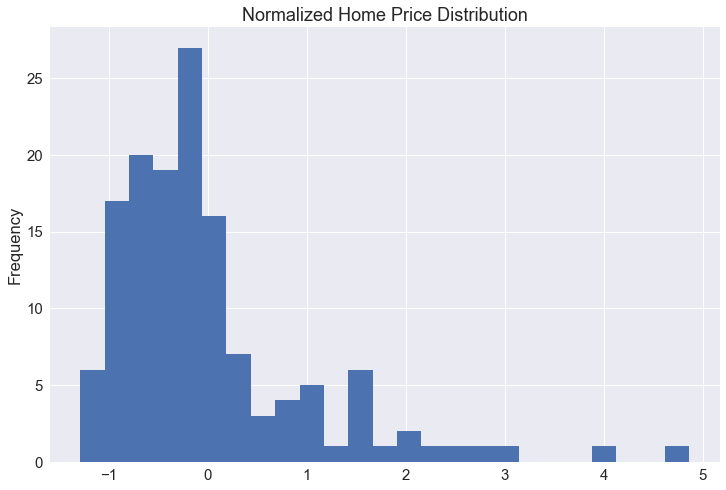

In [28]:
df['Home Prices'].plot.hist(bins=25)
plt.title('Normalized Home Price Distribution')

Let's see if we can notice any strong relationship between `Home Prices` and any individual feature column. To help us visualize this we'll define a `Price Category` column that breaks `Home Prices` into quartiles.

In [29]:
feature_cols = df.columns.values

In [30]:
df['Price Category'] = pd.qcut(df['Home Prices'], 4, labels=['low', 'mid-low', 'mid-high', 'high'])

Since we have a small dataset with tightly bunched data, we'll use a swarmplot here to help us out. This plots data along a single vertical axis with the restriction that data circles cannot overlap. This pushes data out along the horizontal axis and let's us quickly look for groupings in categorical data.

In our case, we see strong groupings in `Neighbourhood Equity Score`, `Cervical Cancer Screenings`, `Breast Cancer Screenings`, and `Assaults`. Overall, across all of the Health and Crime features we see at least a weak relationship between `Price Category` and the given feature.

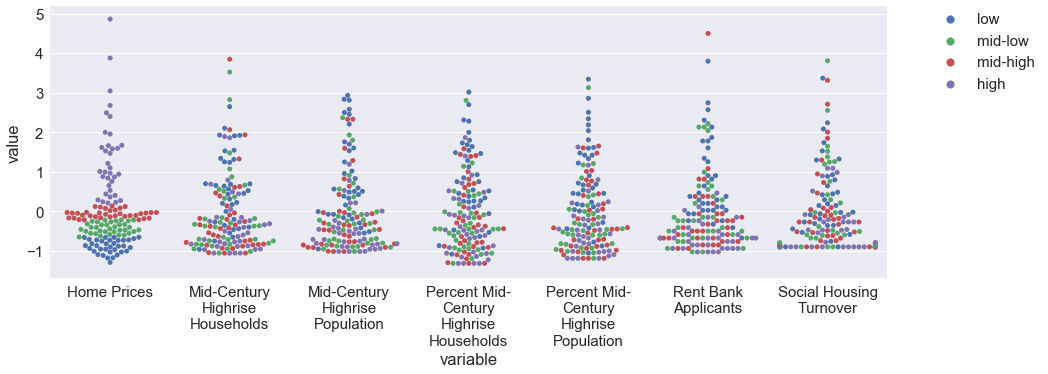

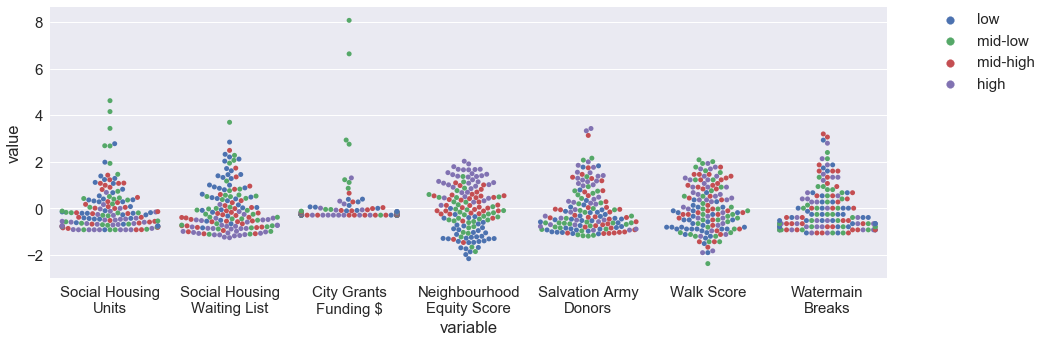

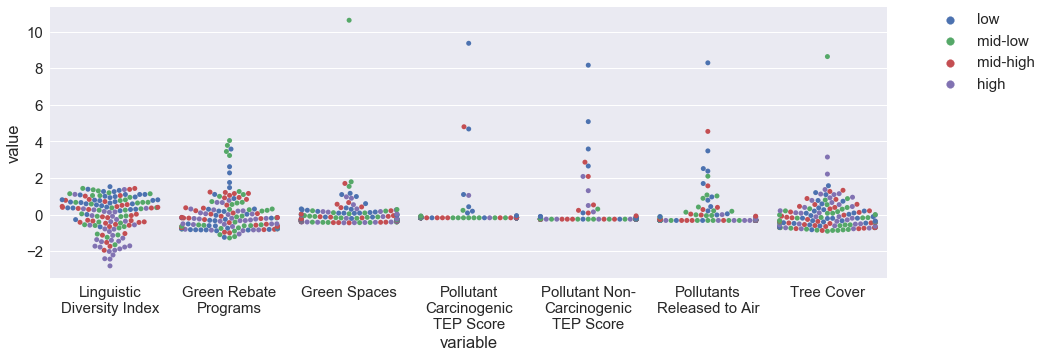

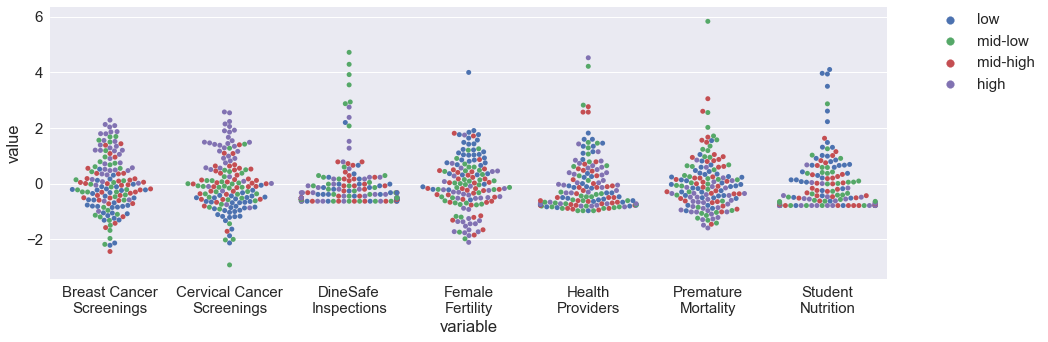

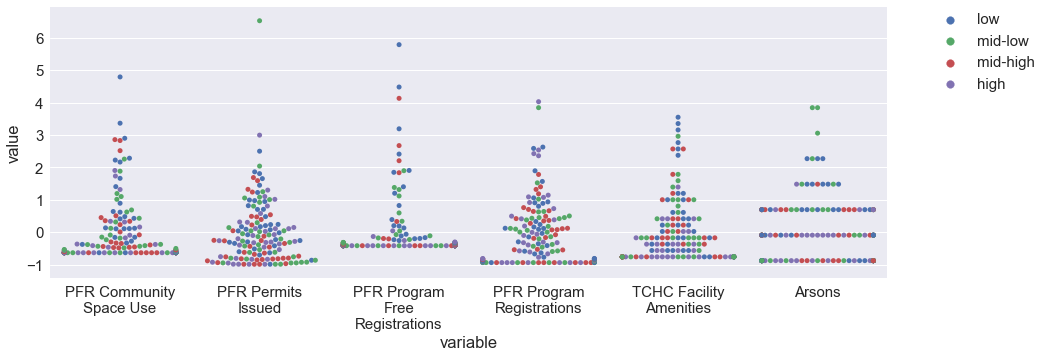

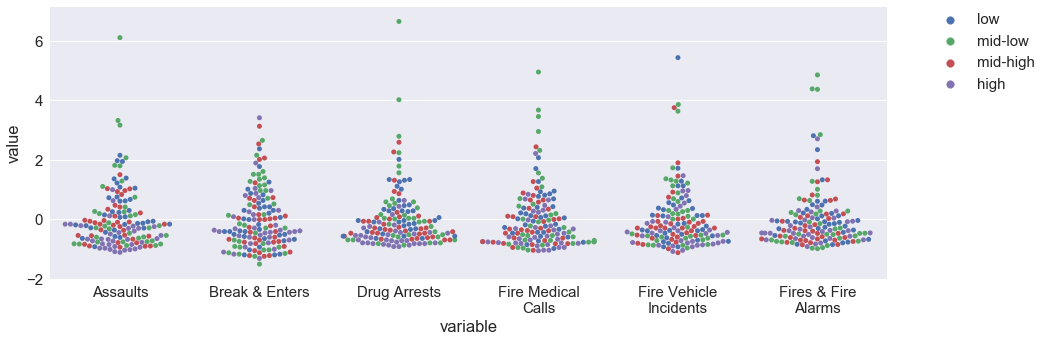

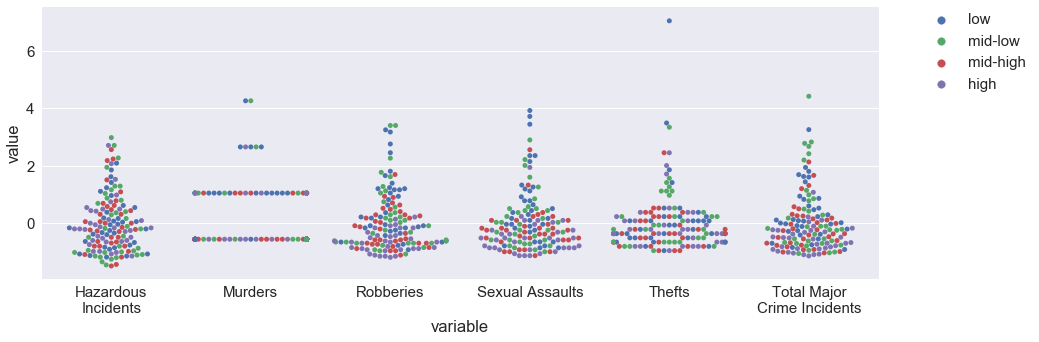

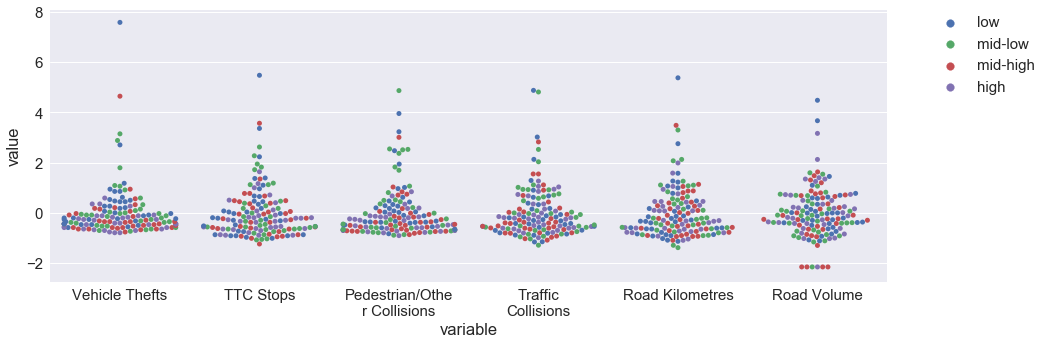

In [36]:
def plotCategories(df, cols):
    fig, ax = plt.subplots(figsize = (15, 5))
    df_long = pd.melt(df[cols + ['Price Category']], id_vars='Price Category')
    g = sns.swarmplot(x='variable', y='value', hue='Price Category', data=df_long)
    wrapped_labels = [ '\n'.join(wrap(l.get_text(), 15)) for l in g.get_xticklabels() ]
    g.set_xticklabels(wrapped_labels)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for chunk in np.array_split(feature_cols, 8):
    plotCategories(df, list(chunk))

Another way for us to slice this data is by using a ranking for each feature column instead of the raw values. This is motivated by the hypothesis that when people are shopping for a home, it isn't as much the absolute value that matters but instead whether or not a neighborhood is better or worse then other neighborhoods. In the sports world, the analogy would be `It doesn't matter what the score is; only whether you win or lose.`

In [46]:
df_rank = df.rank(axis=0)

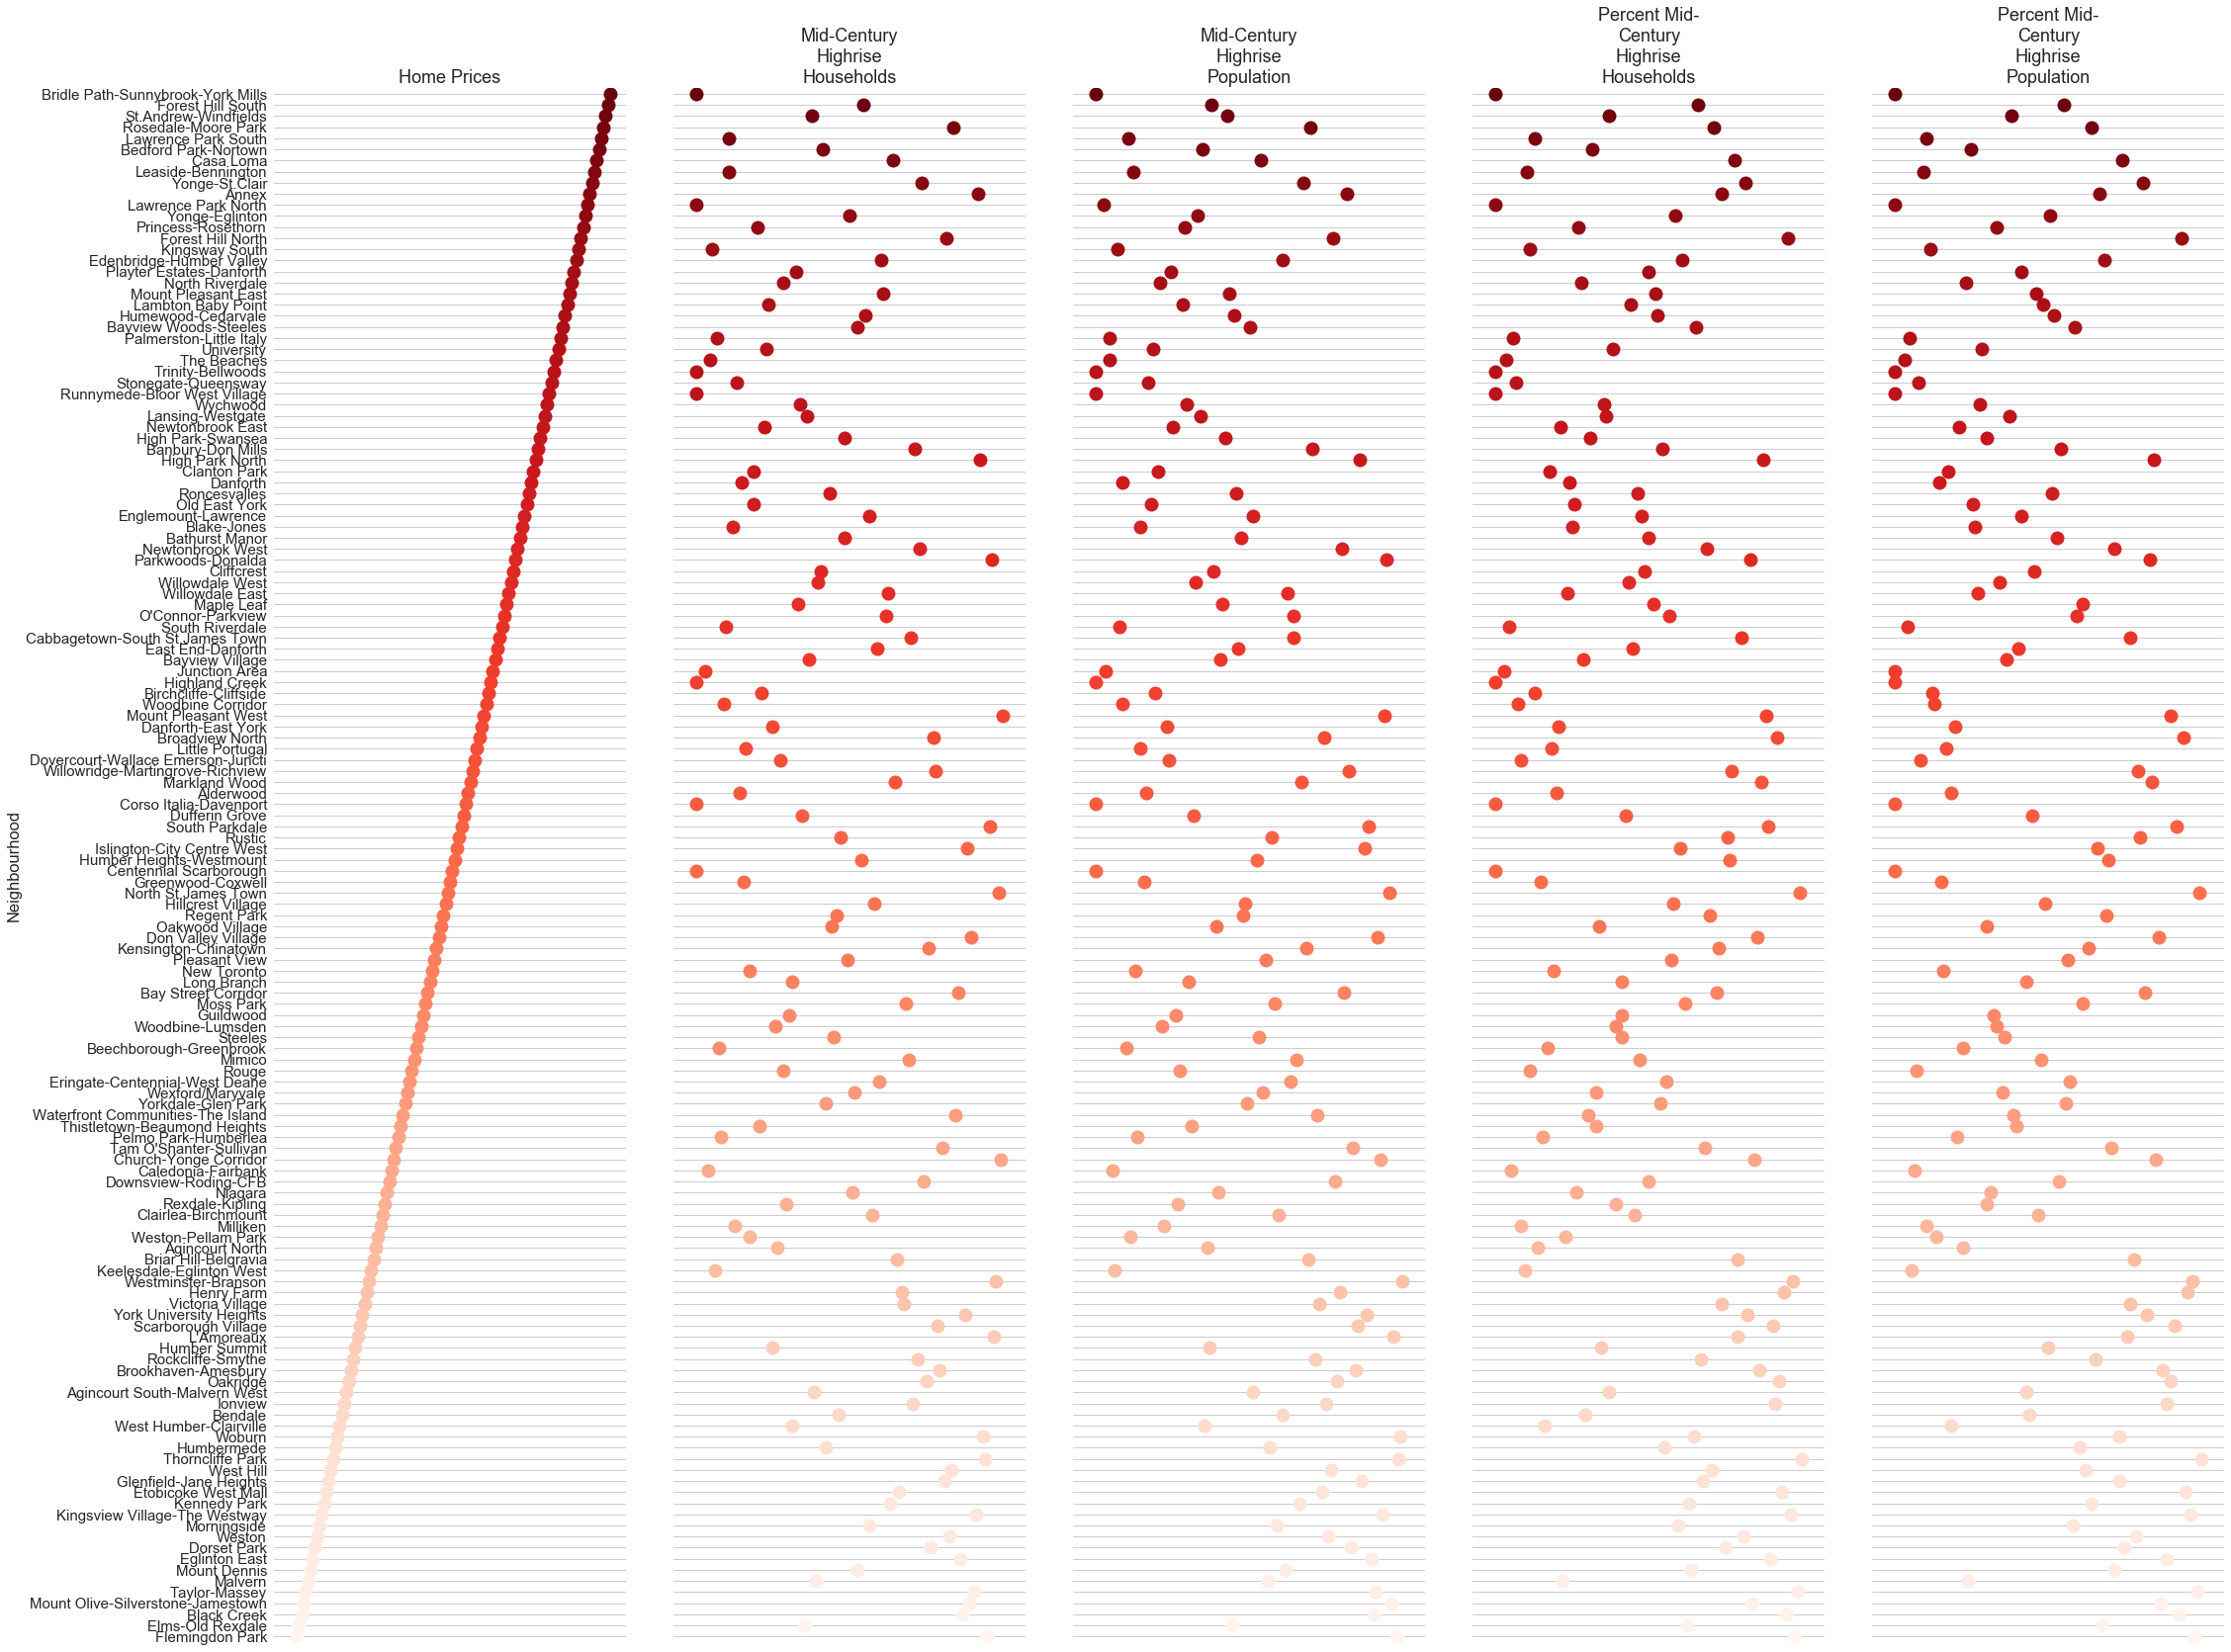

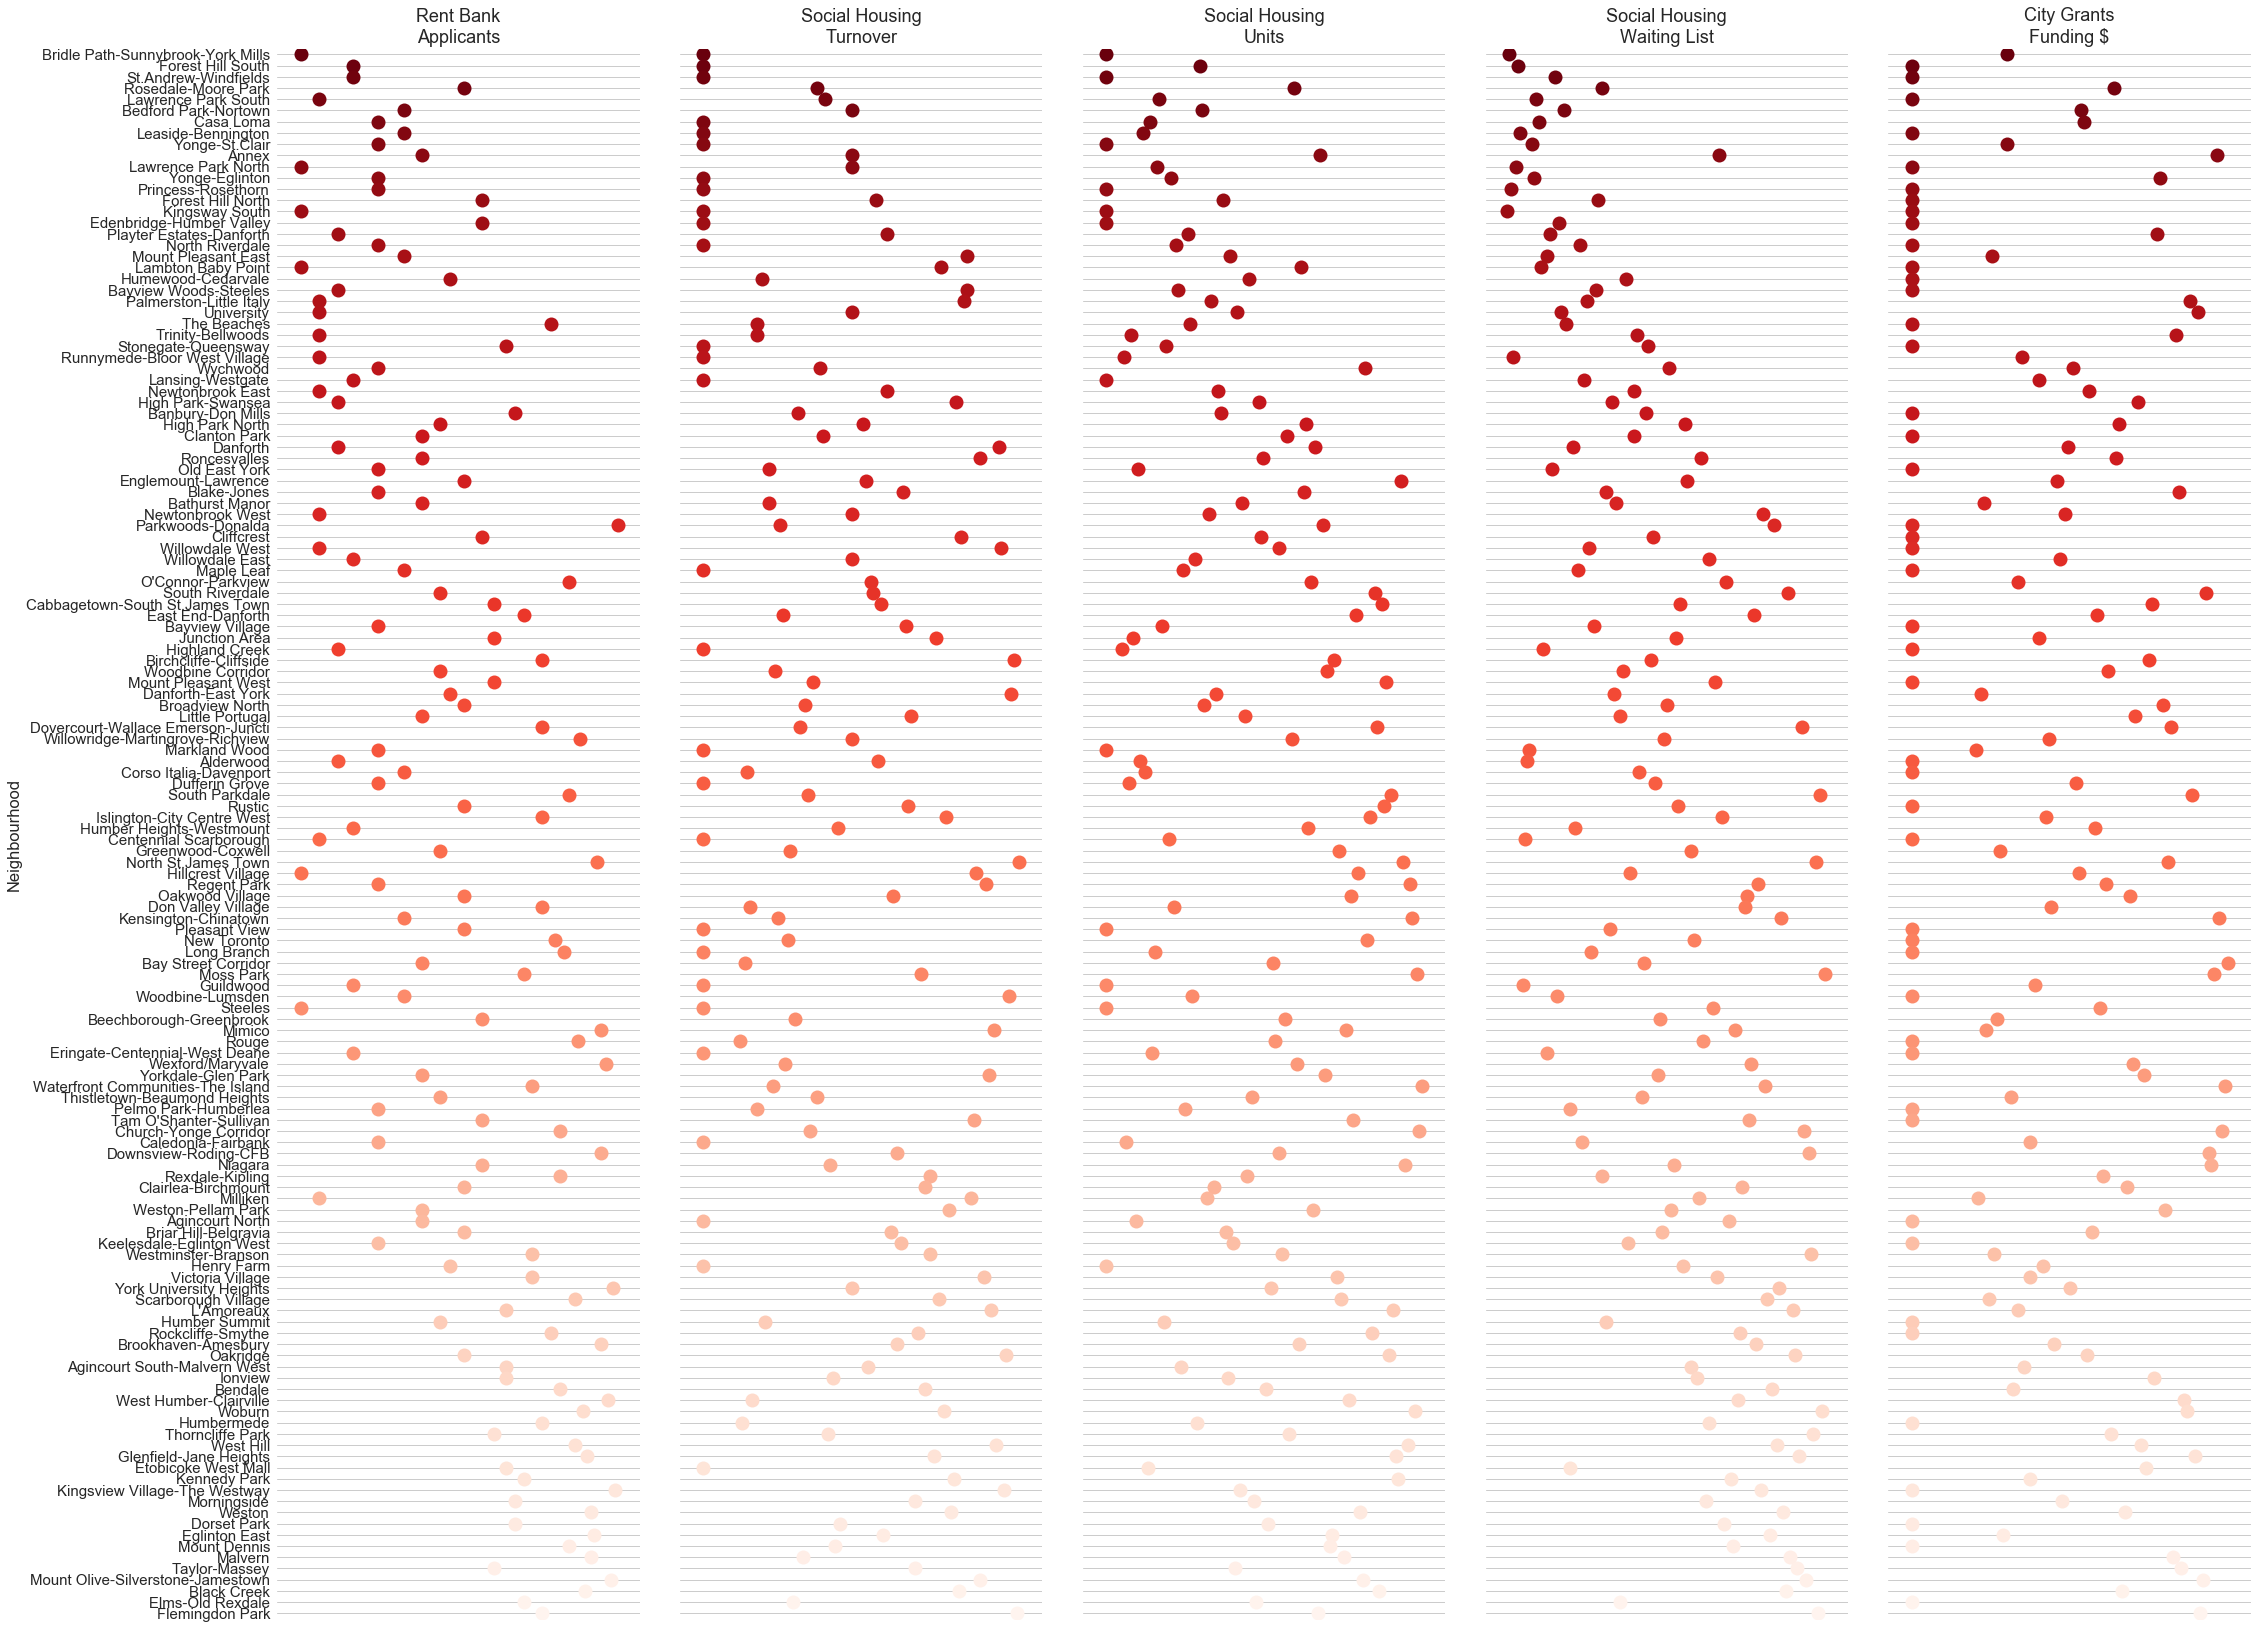

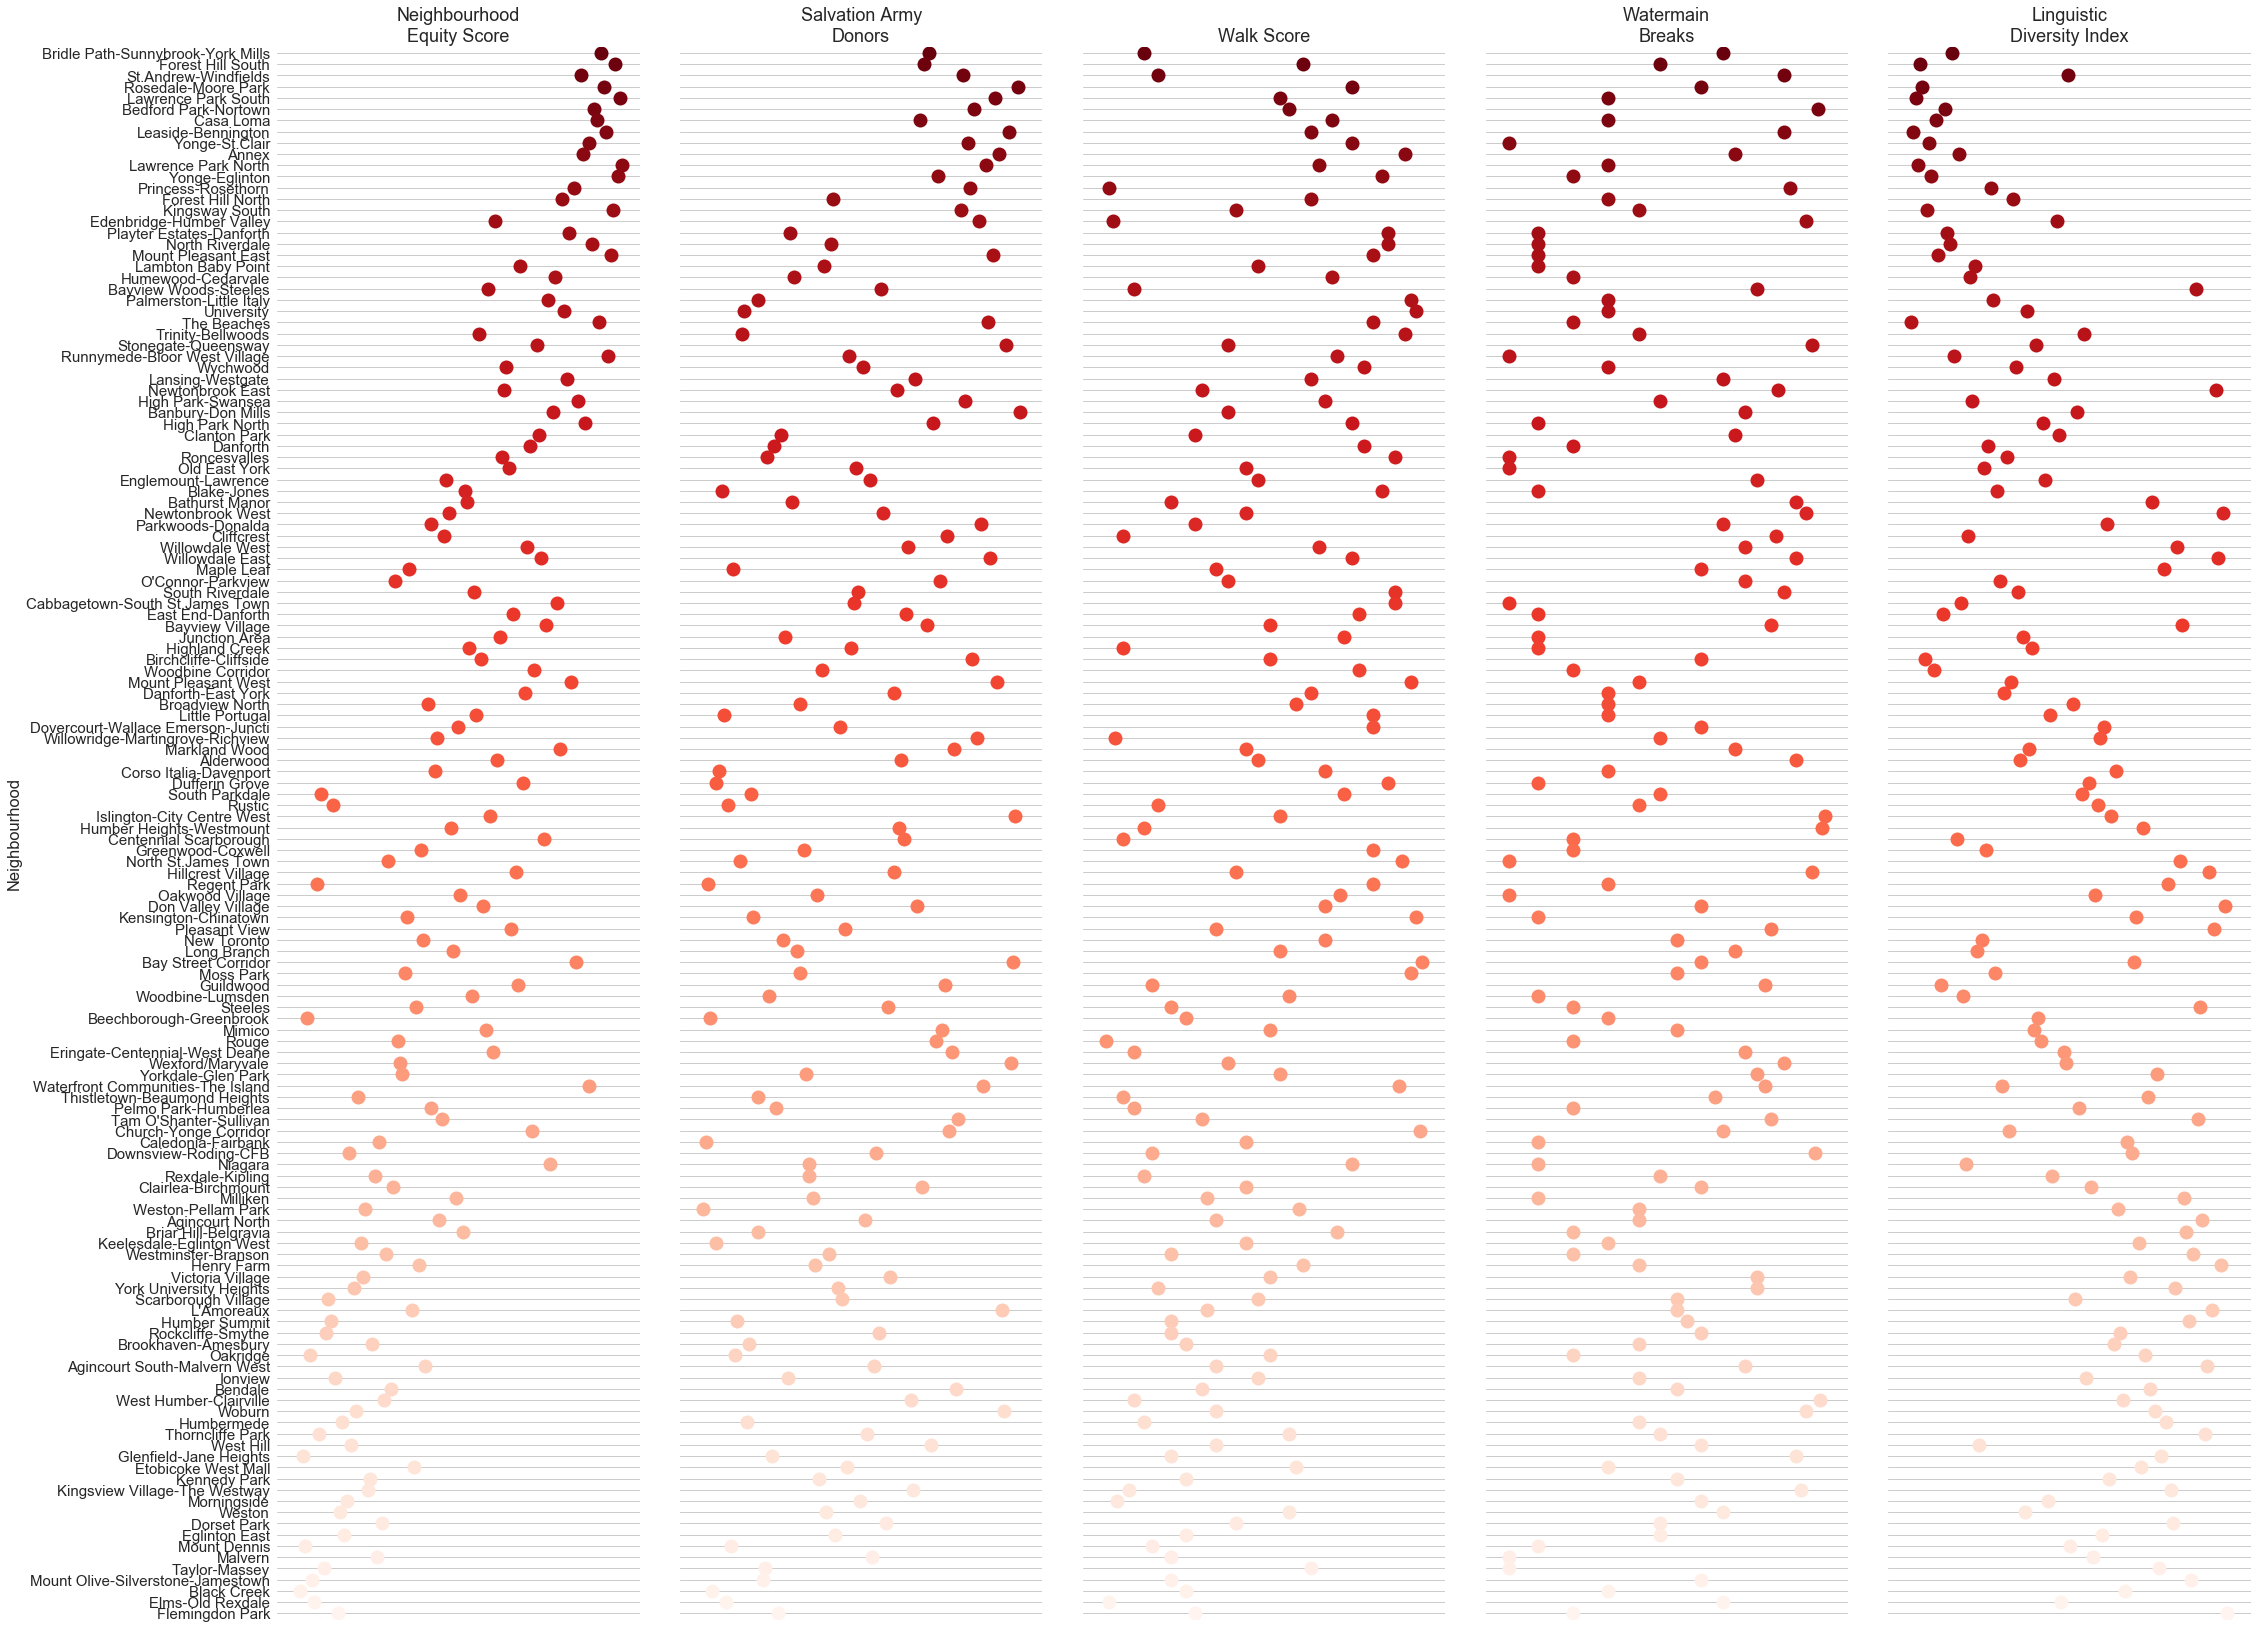

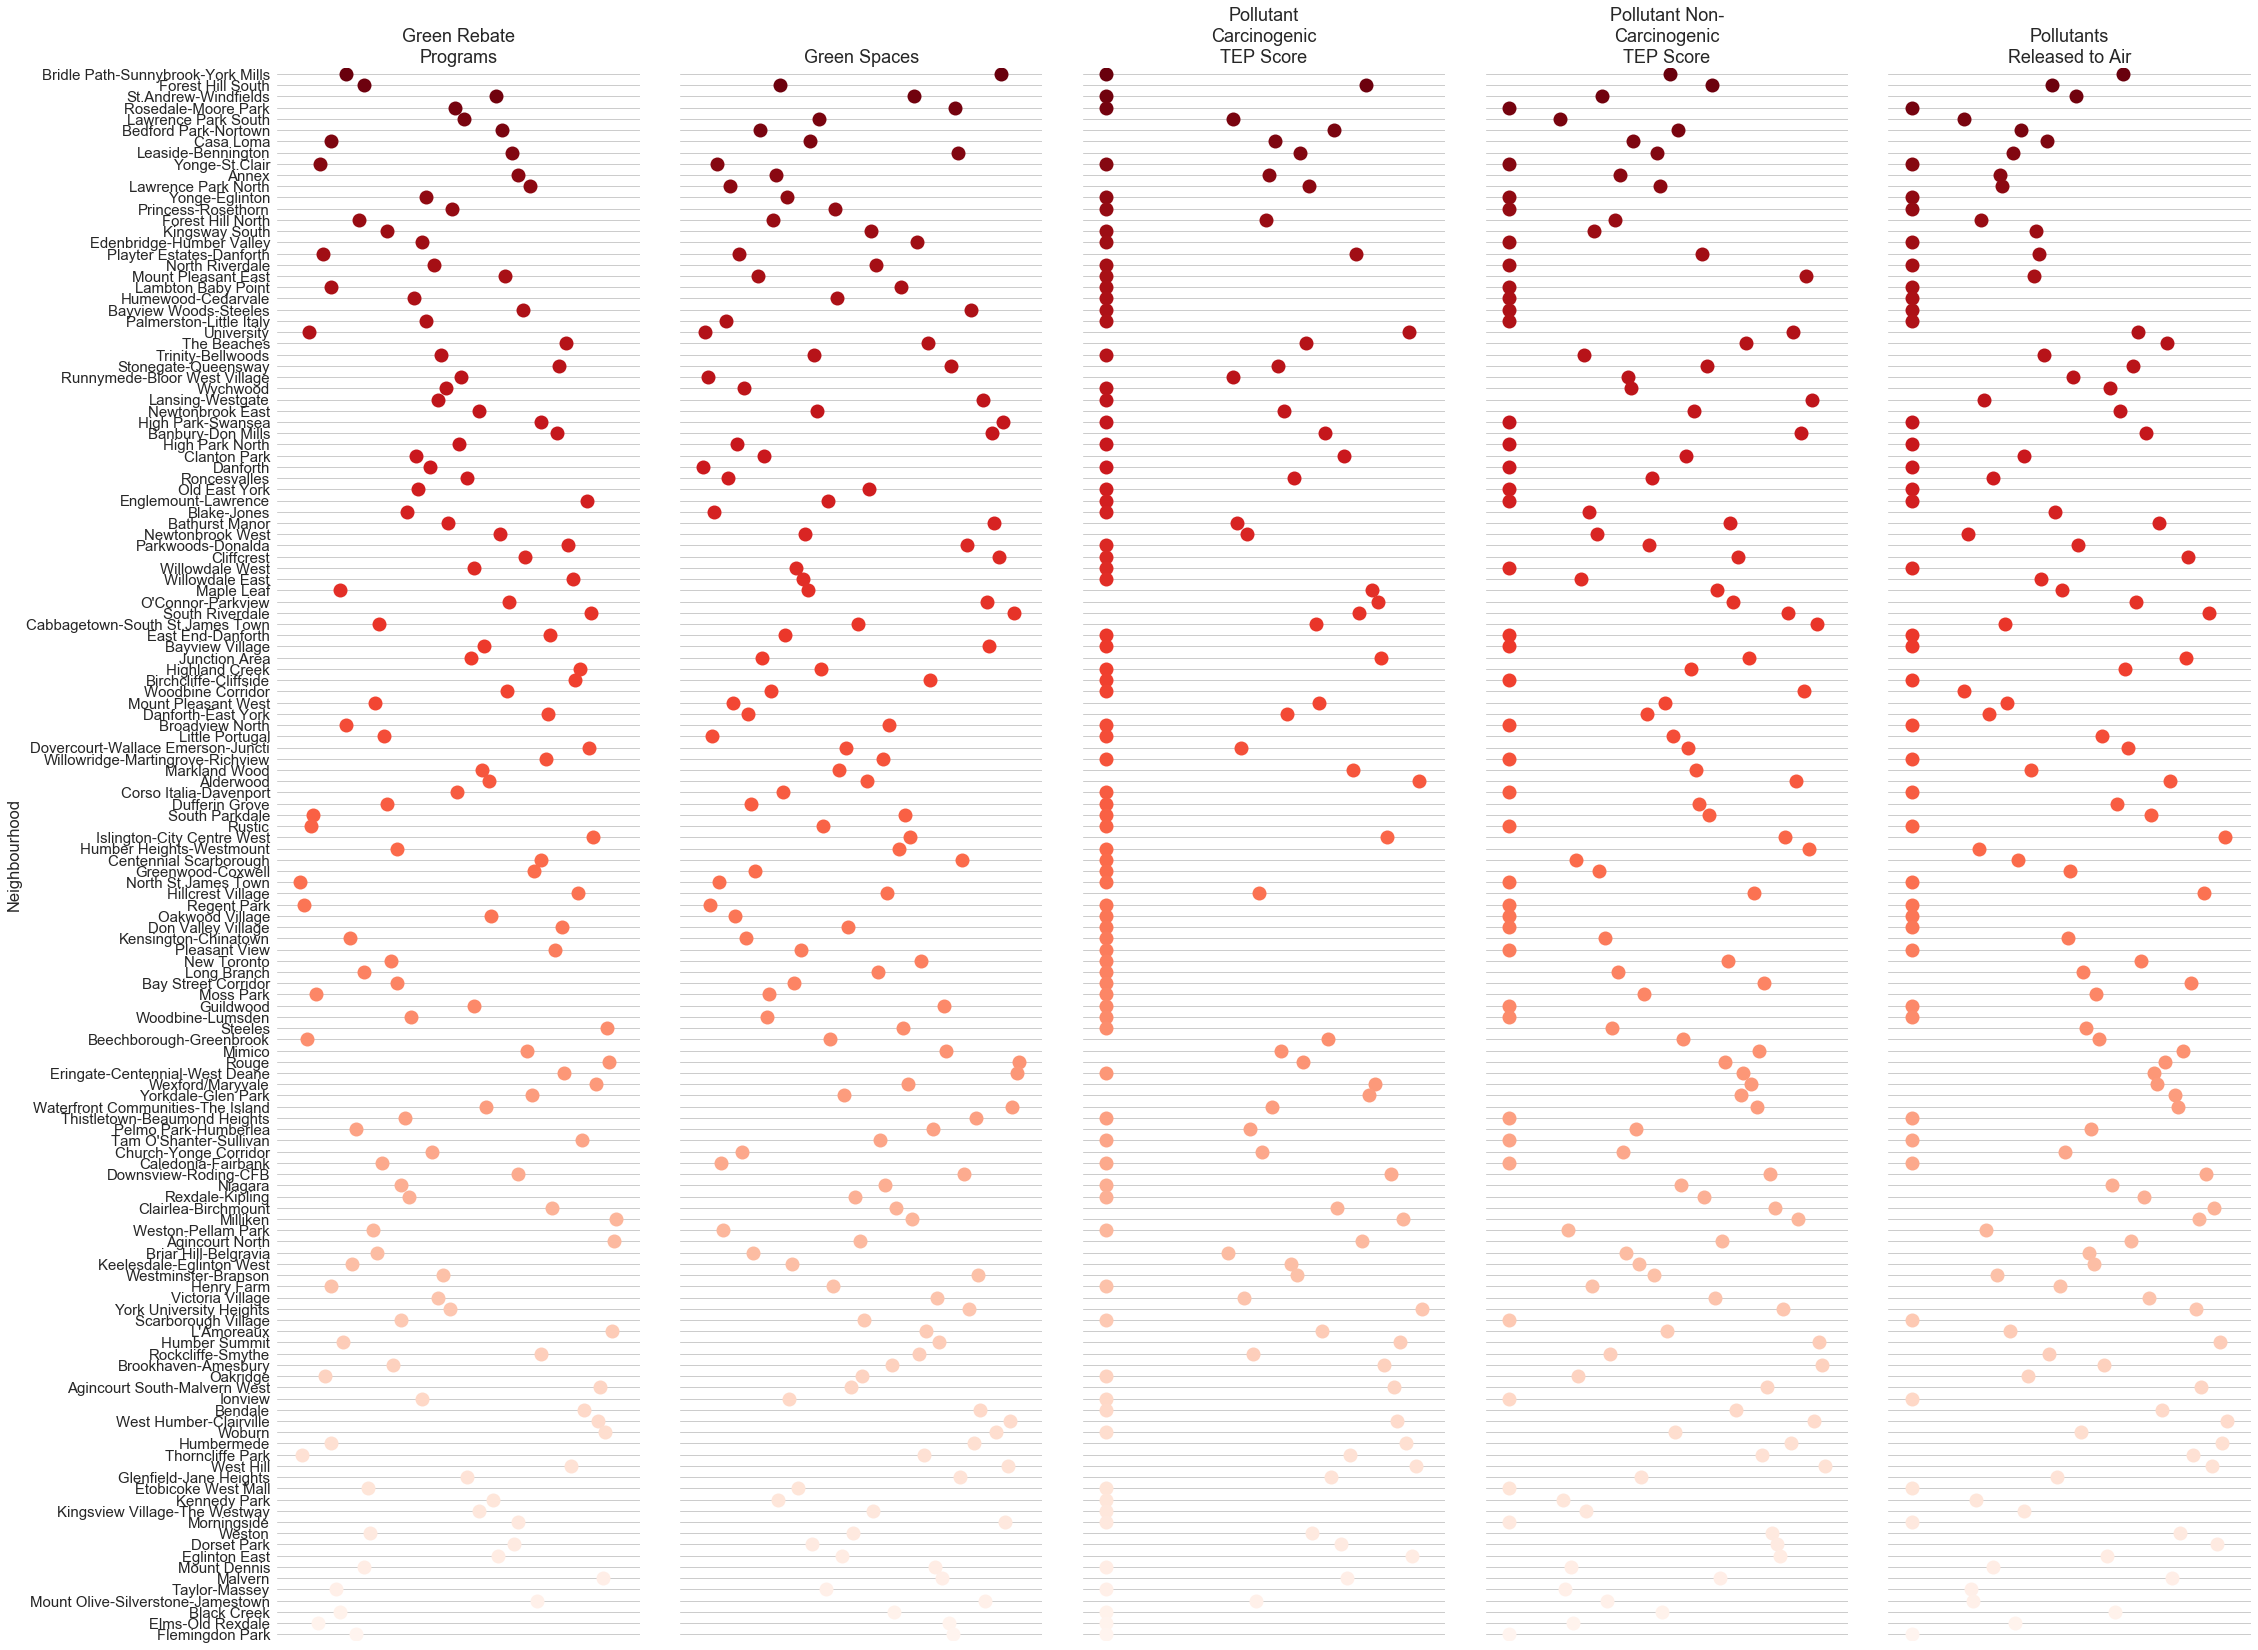

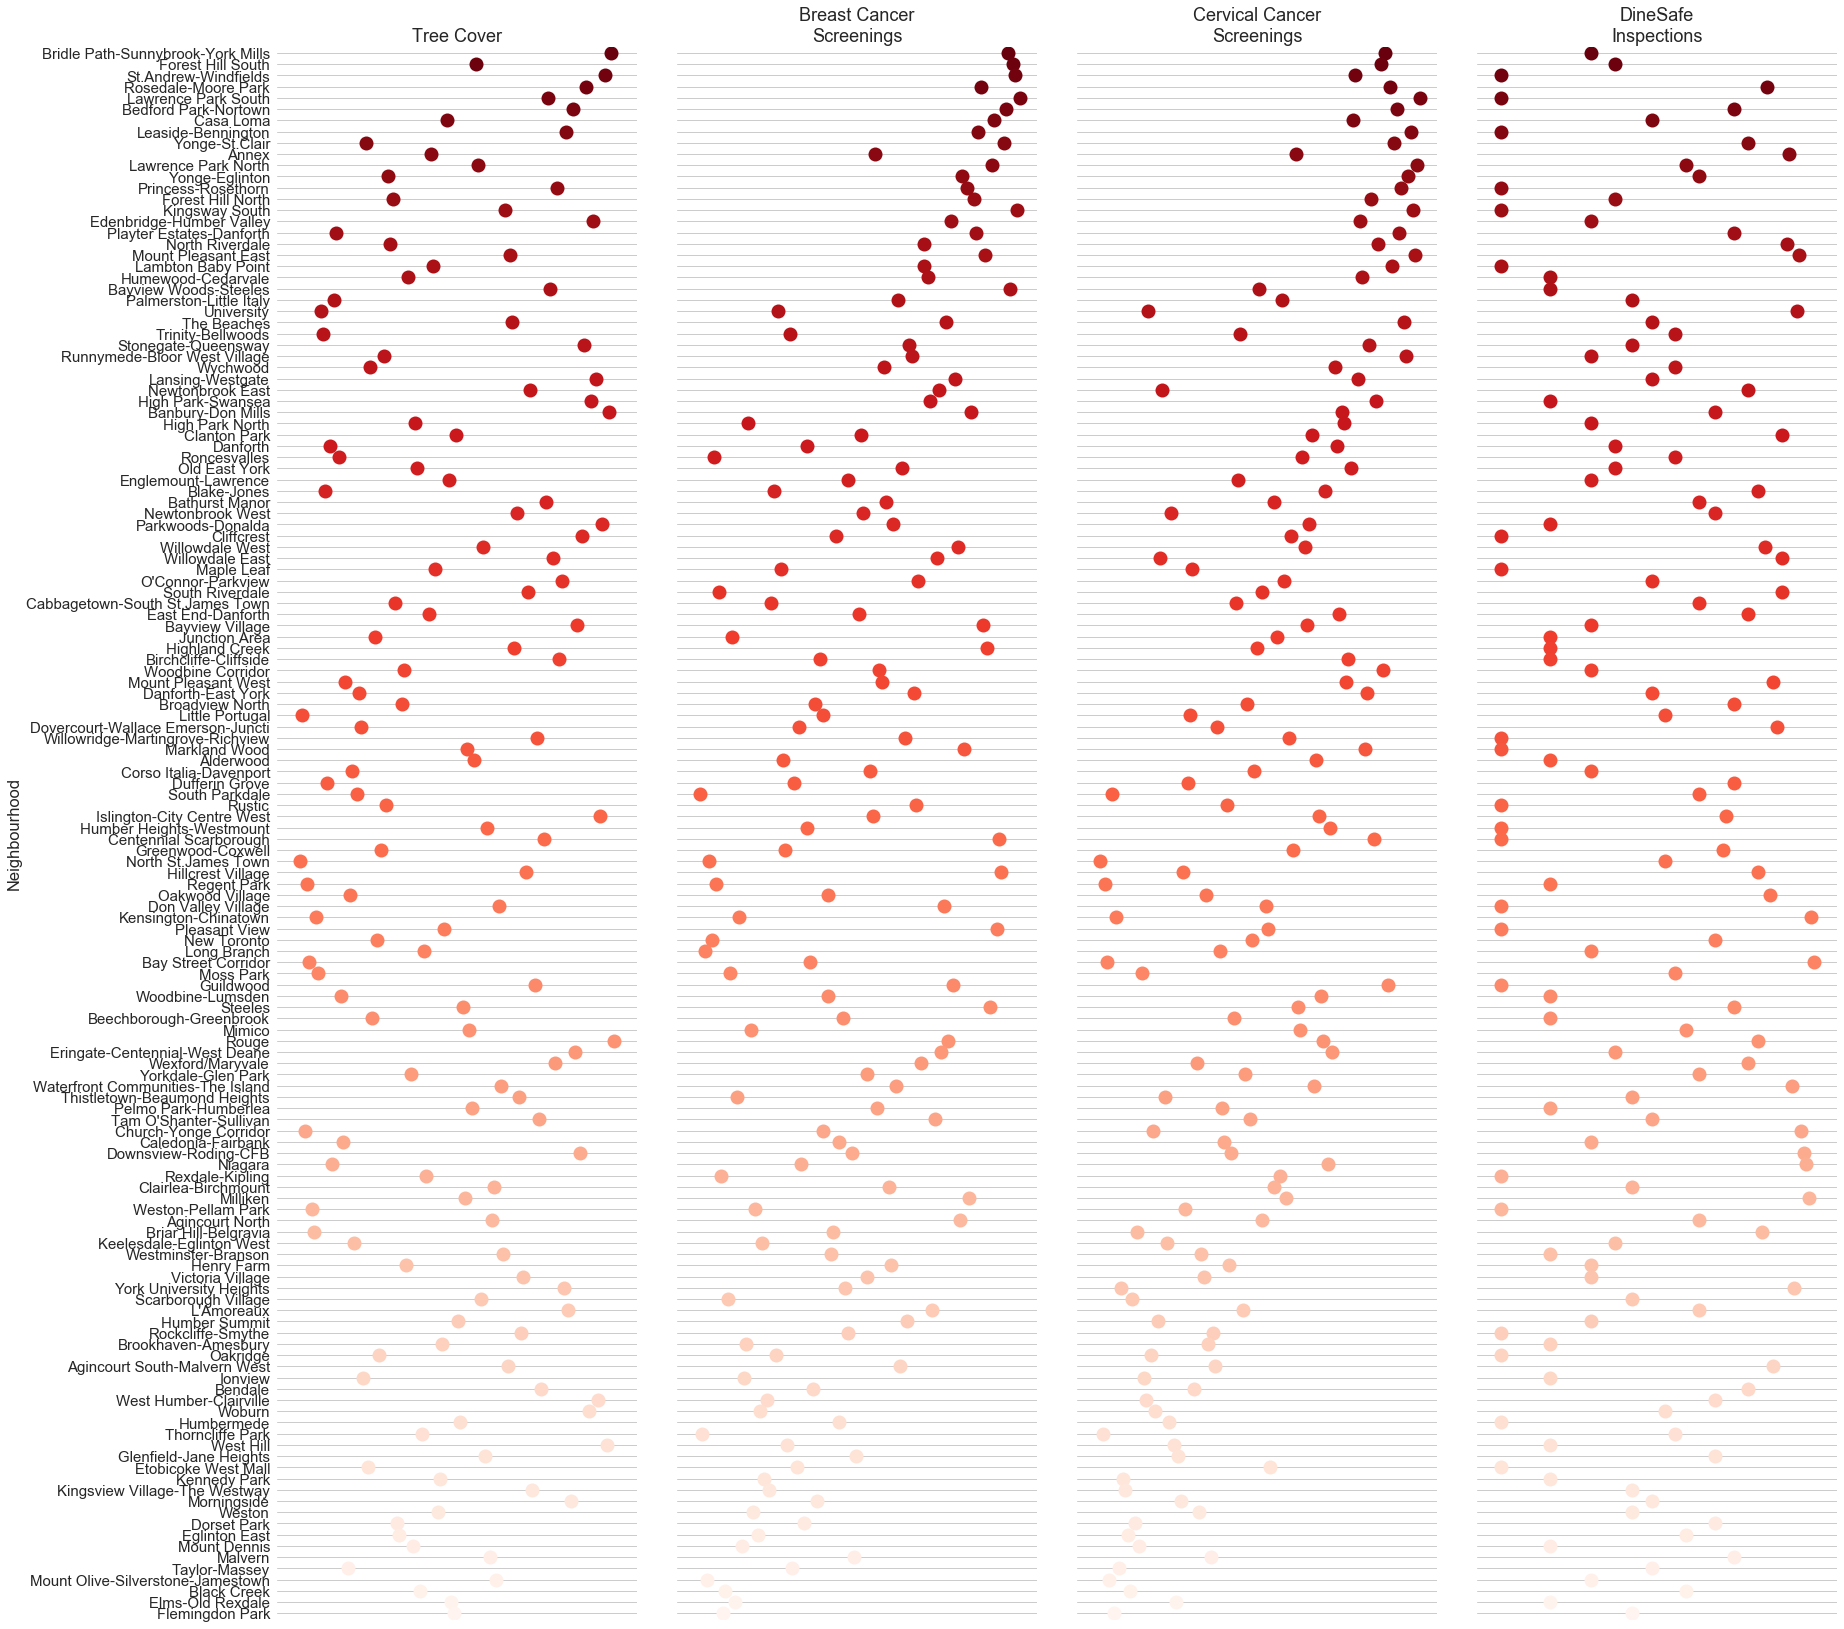

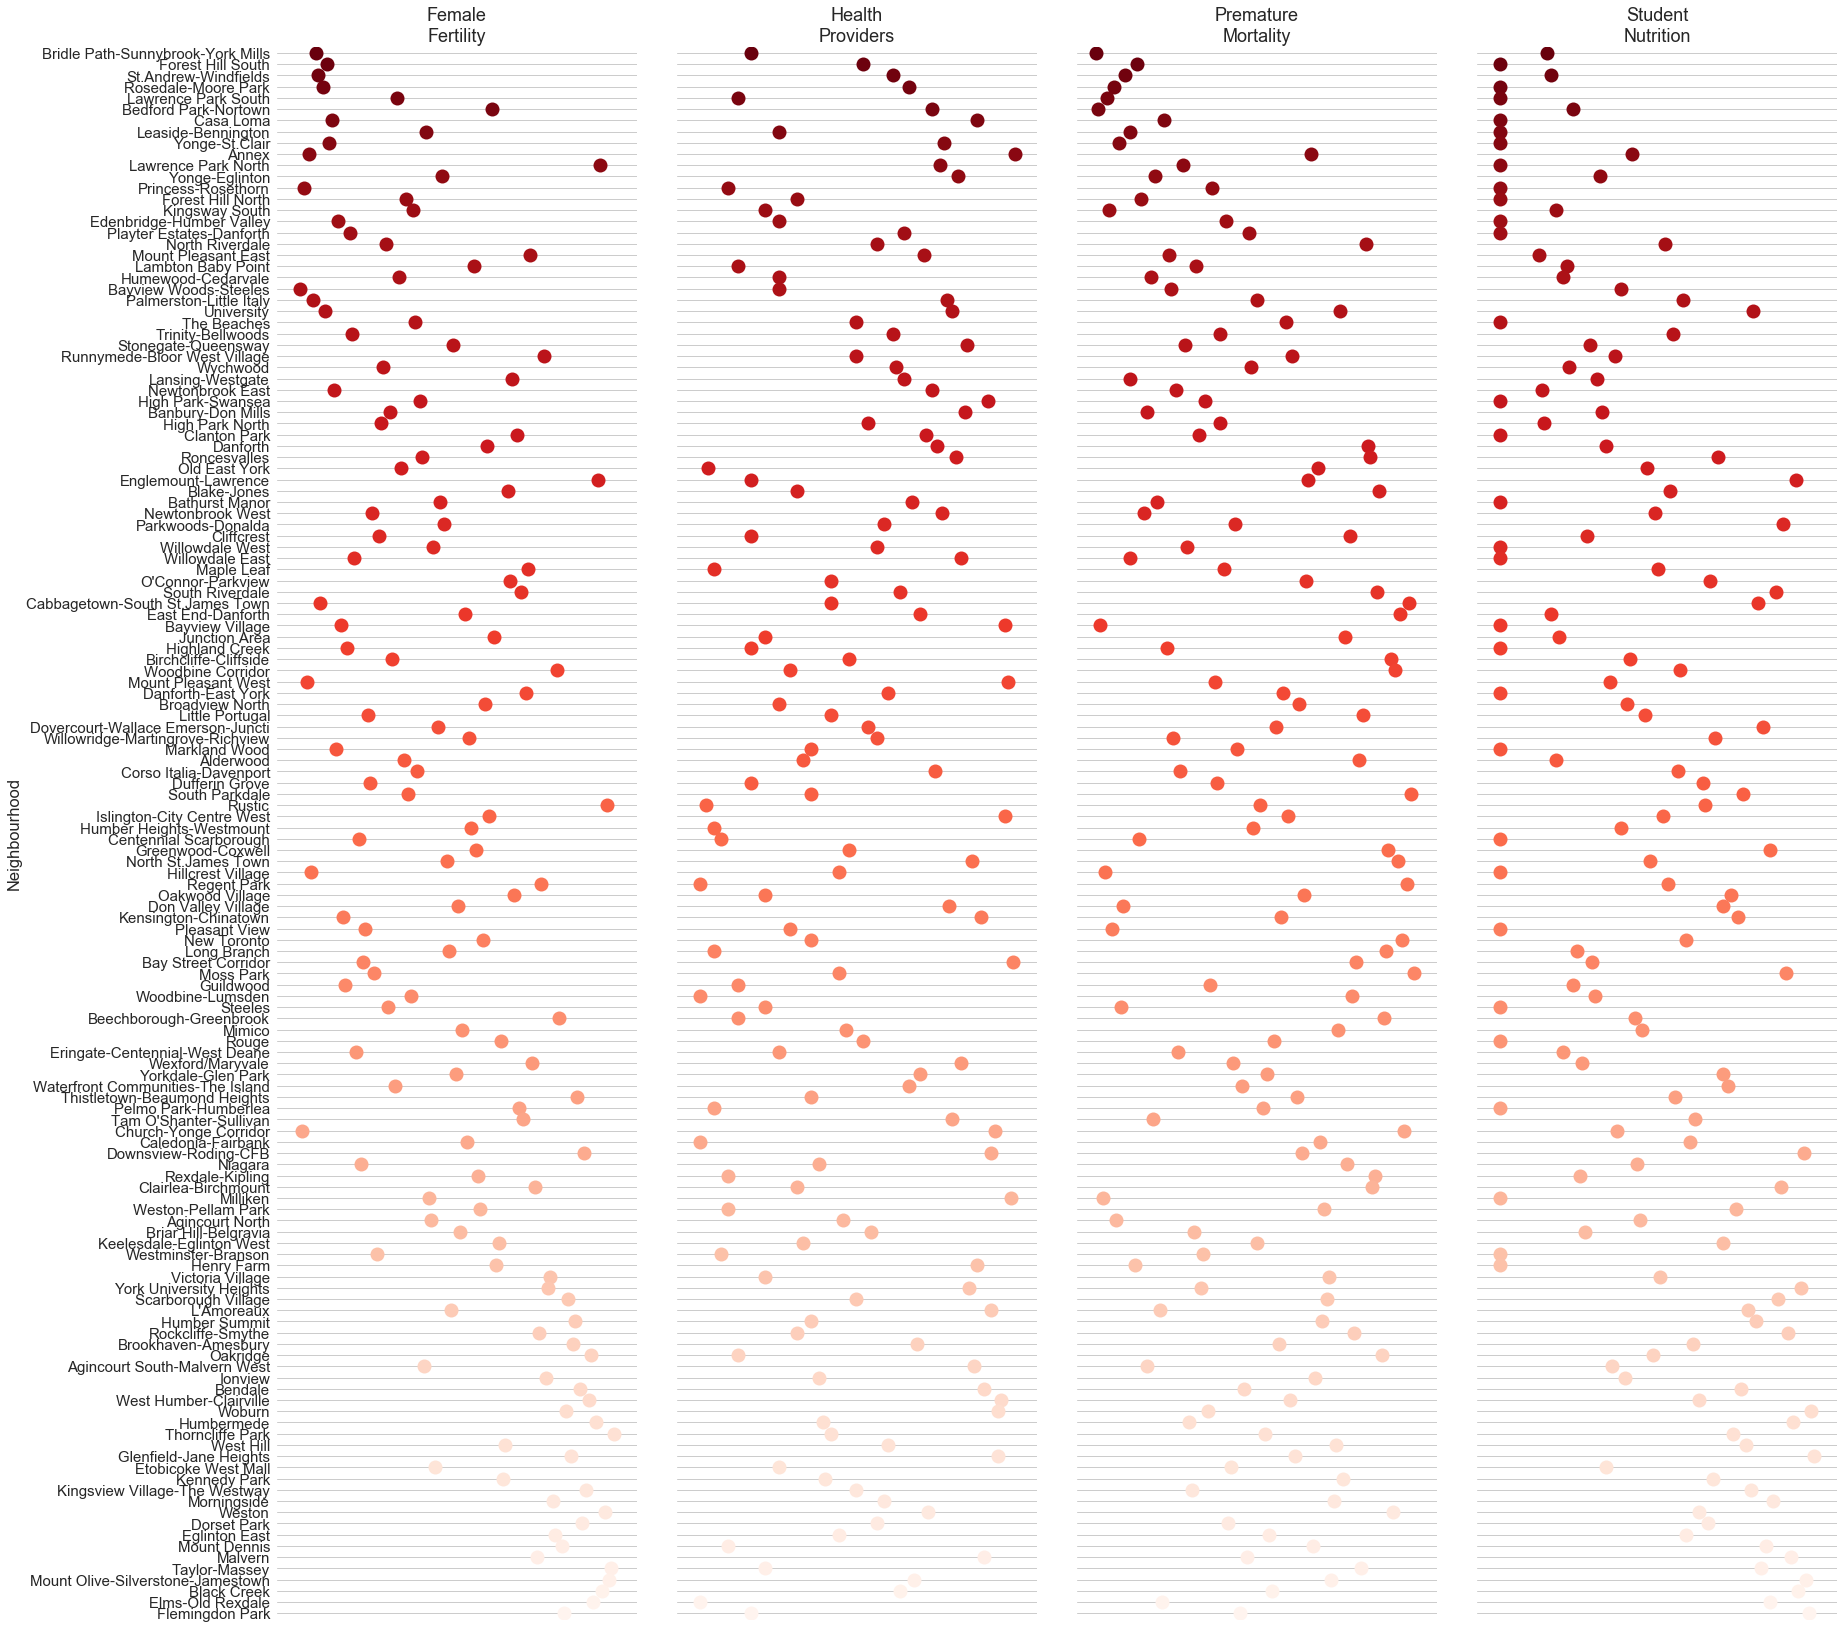

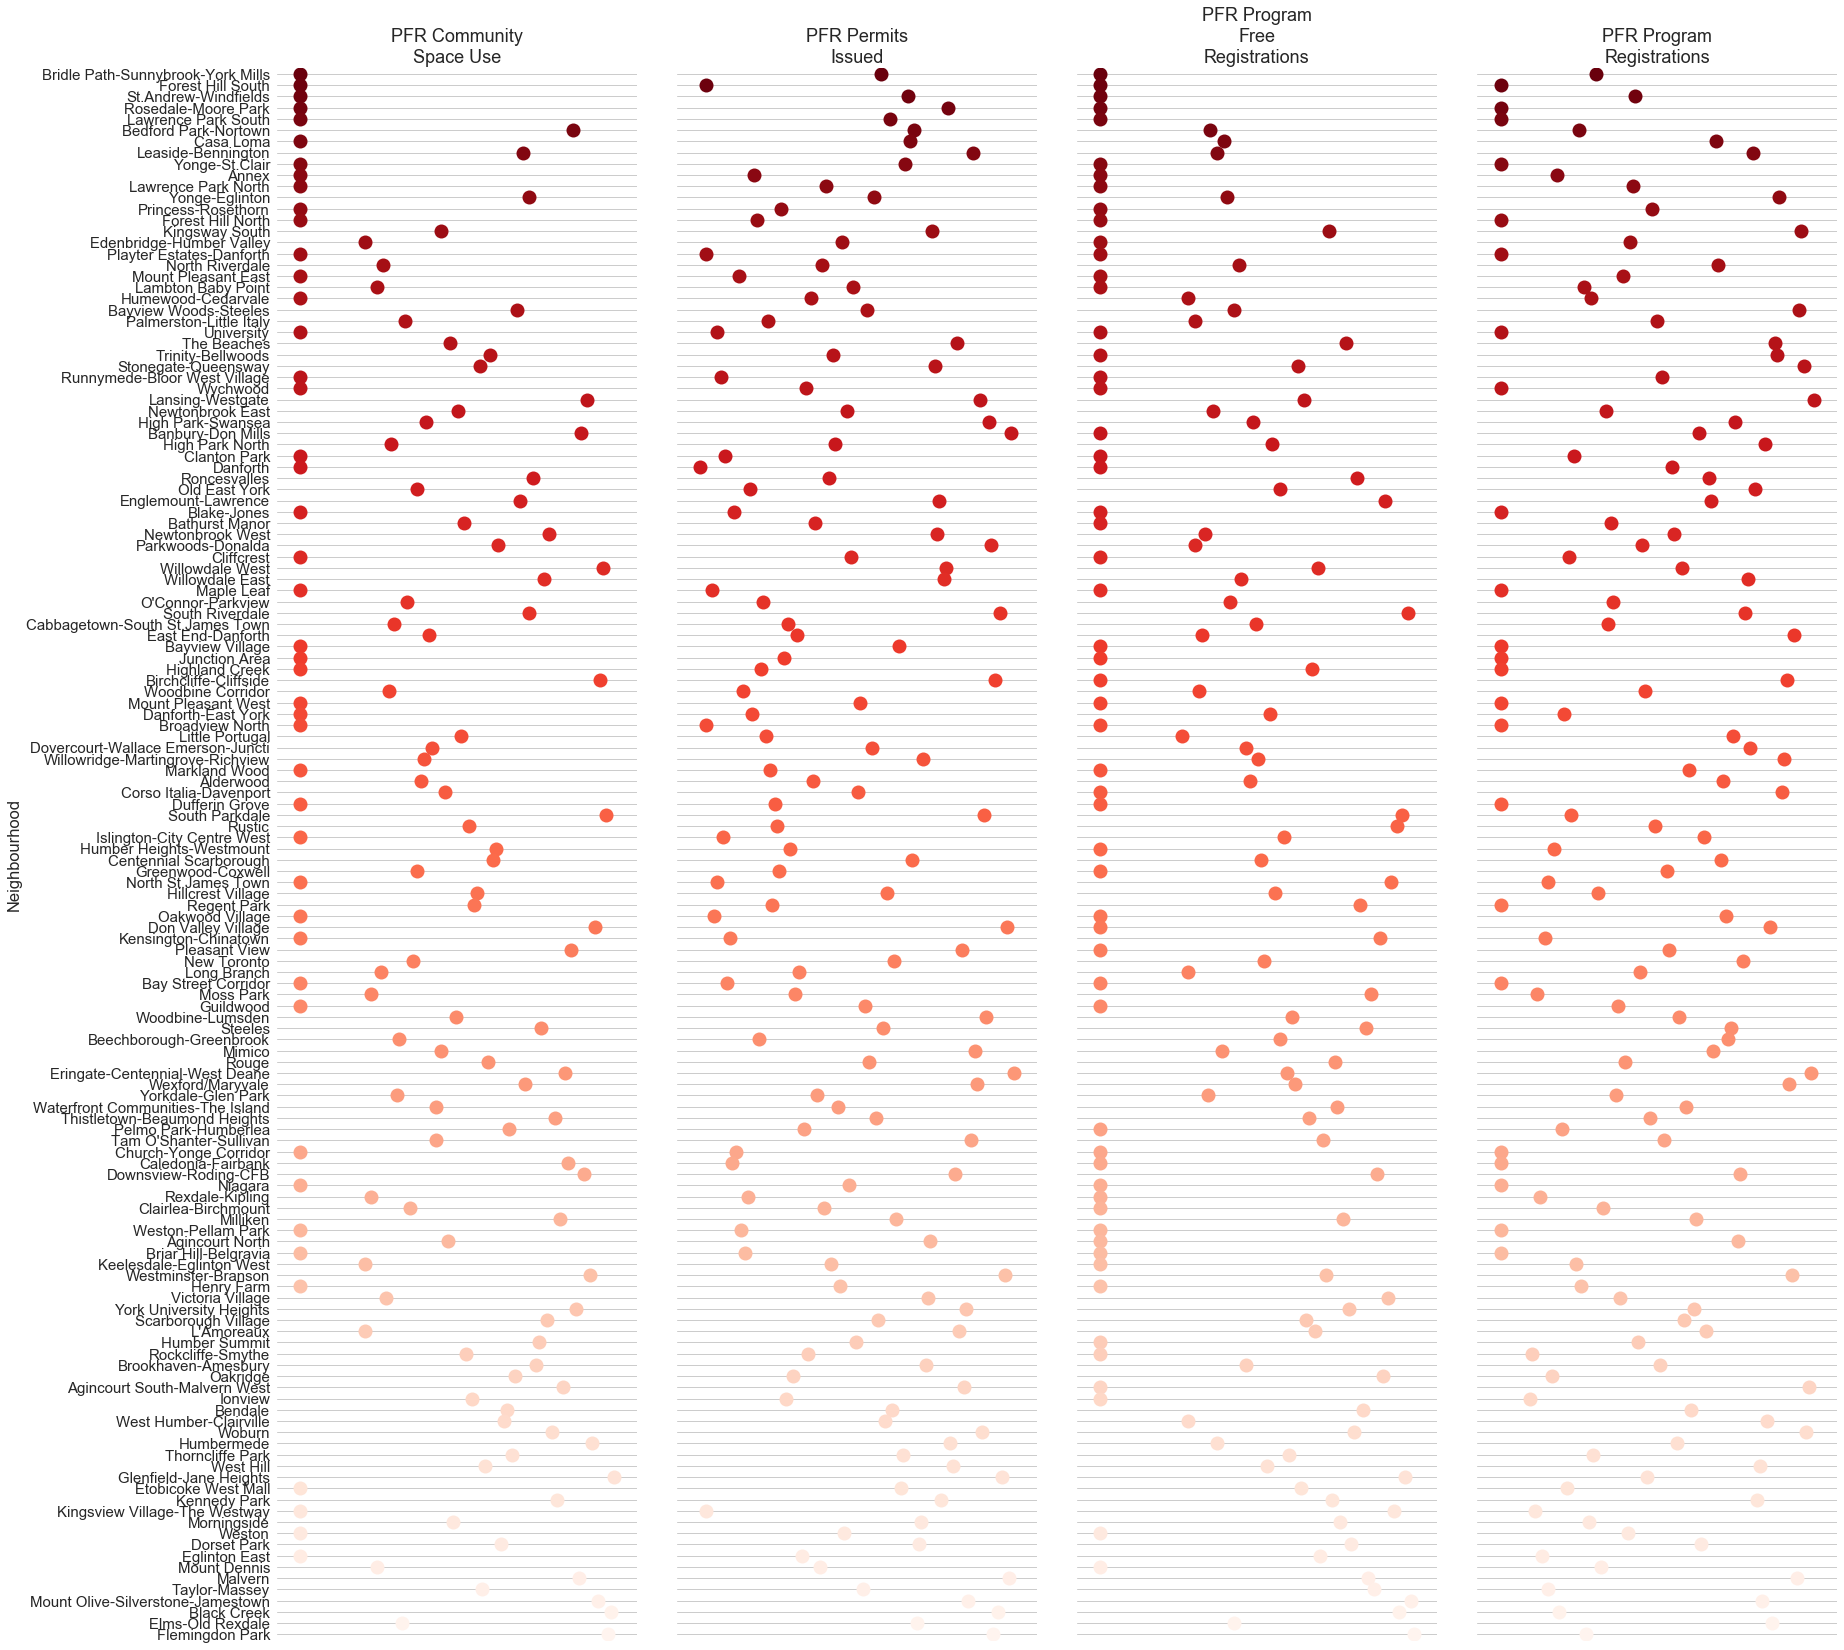

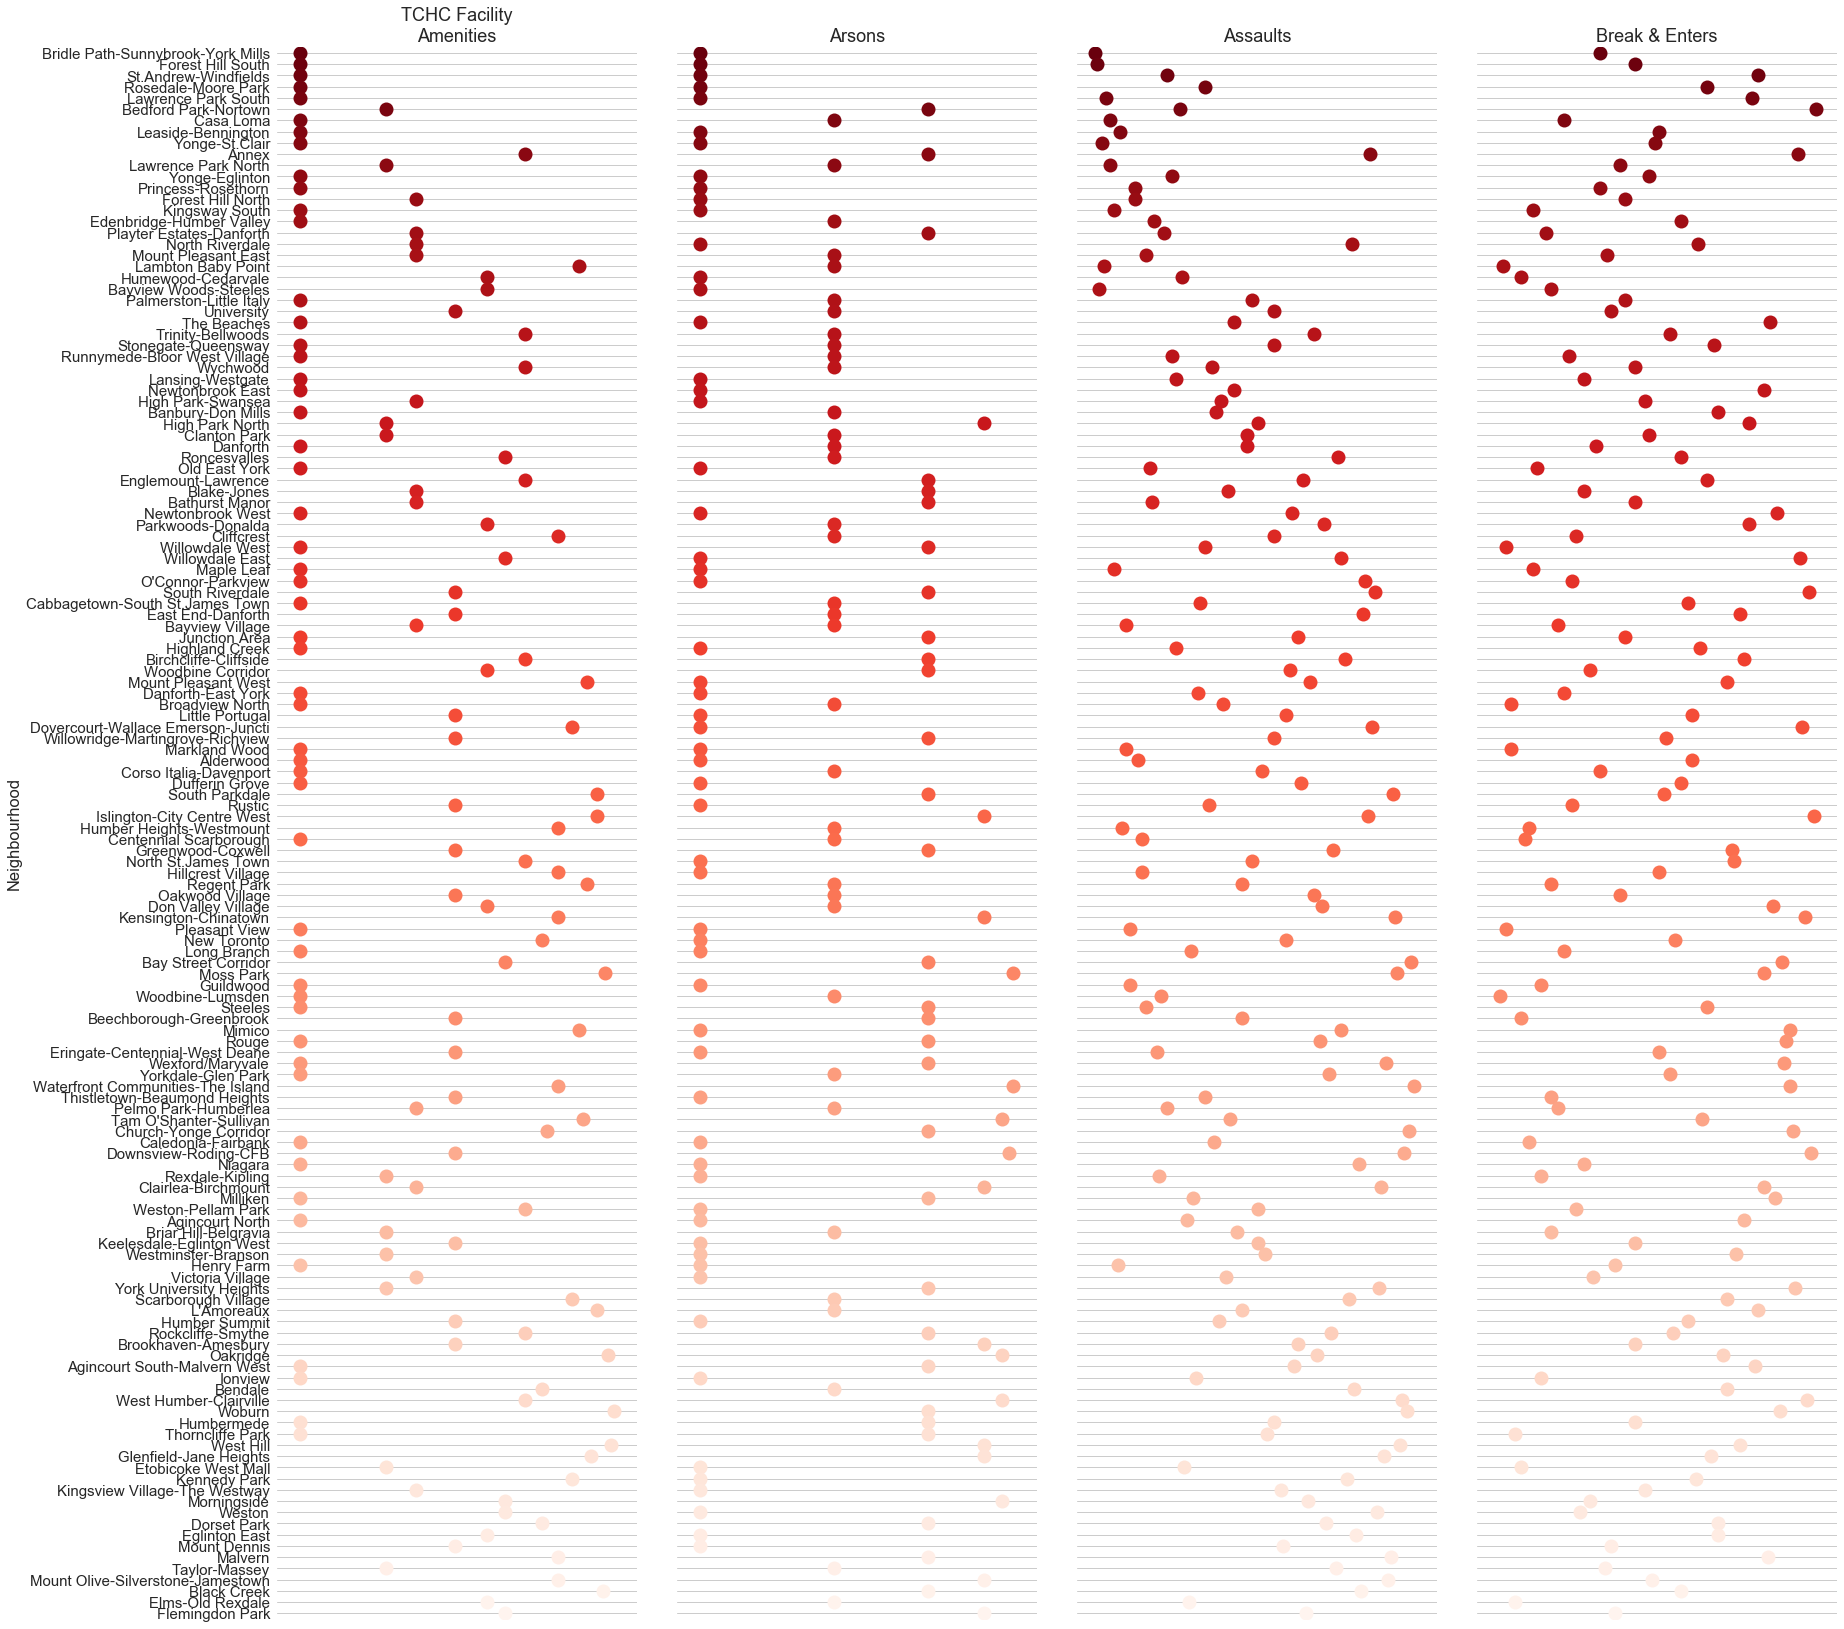

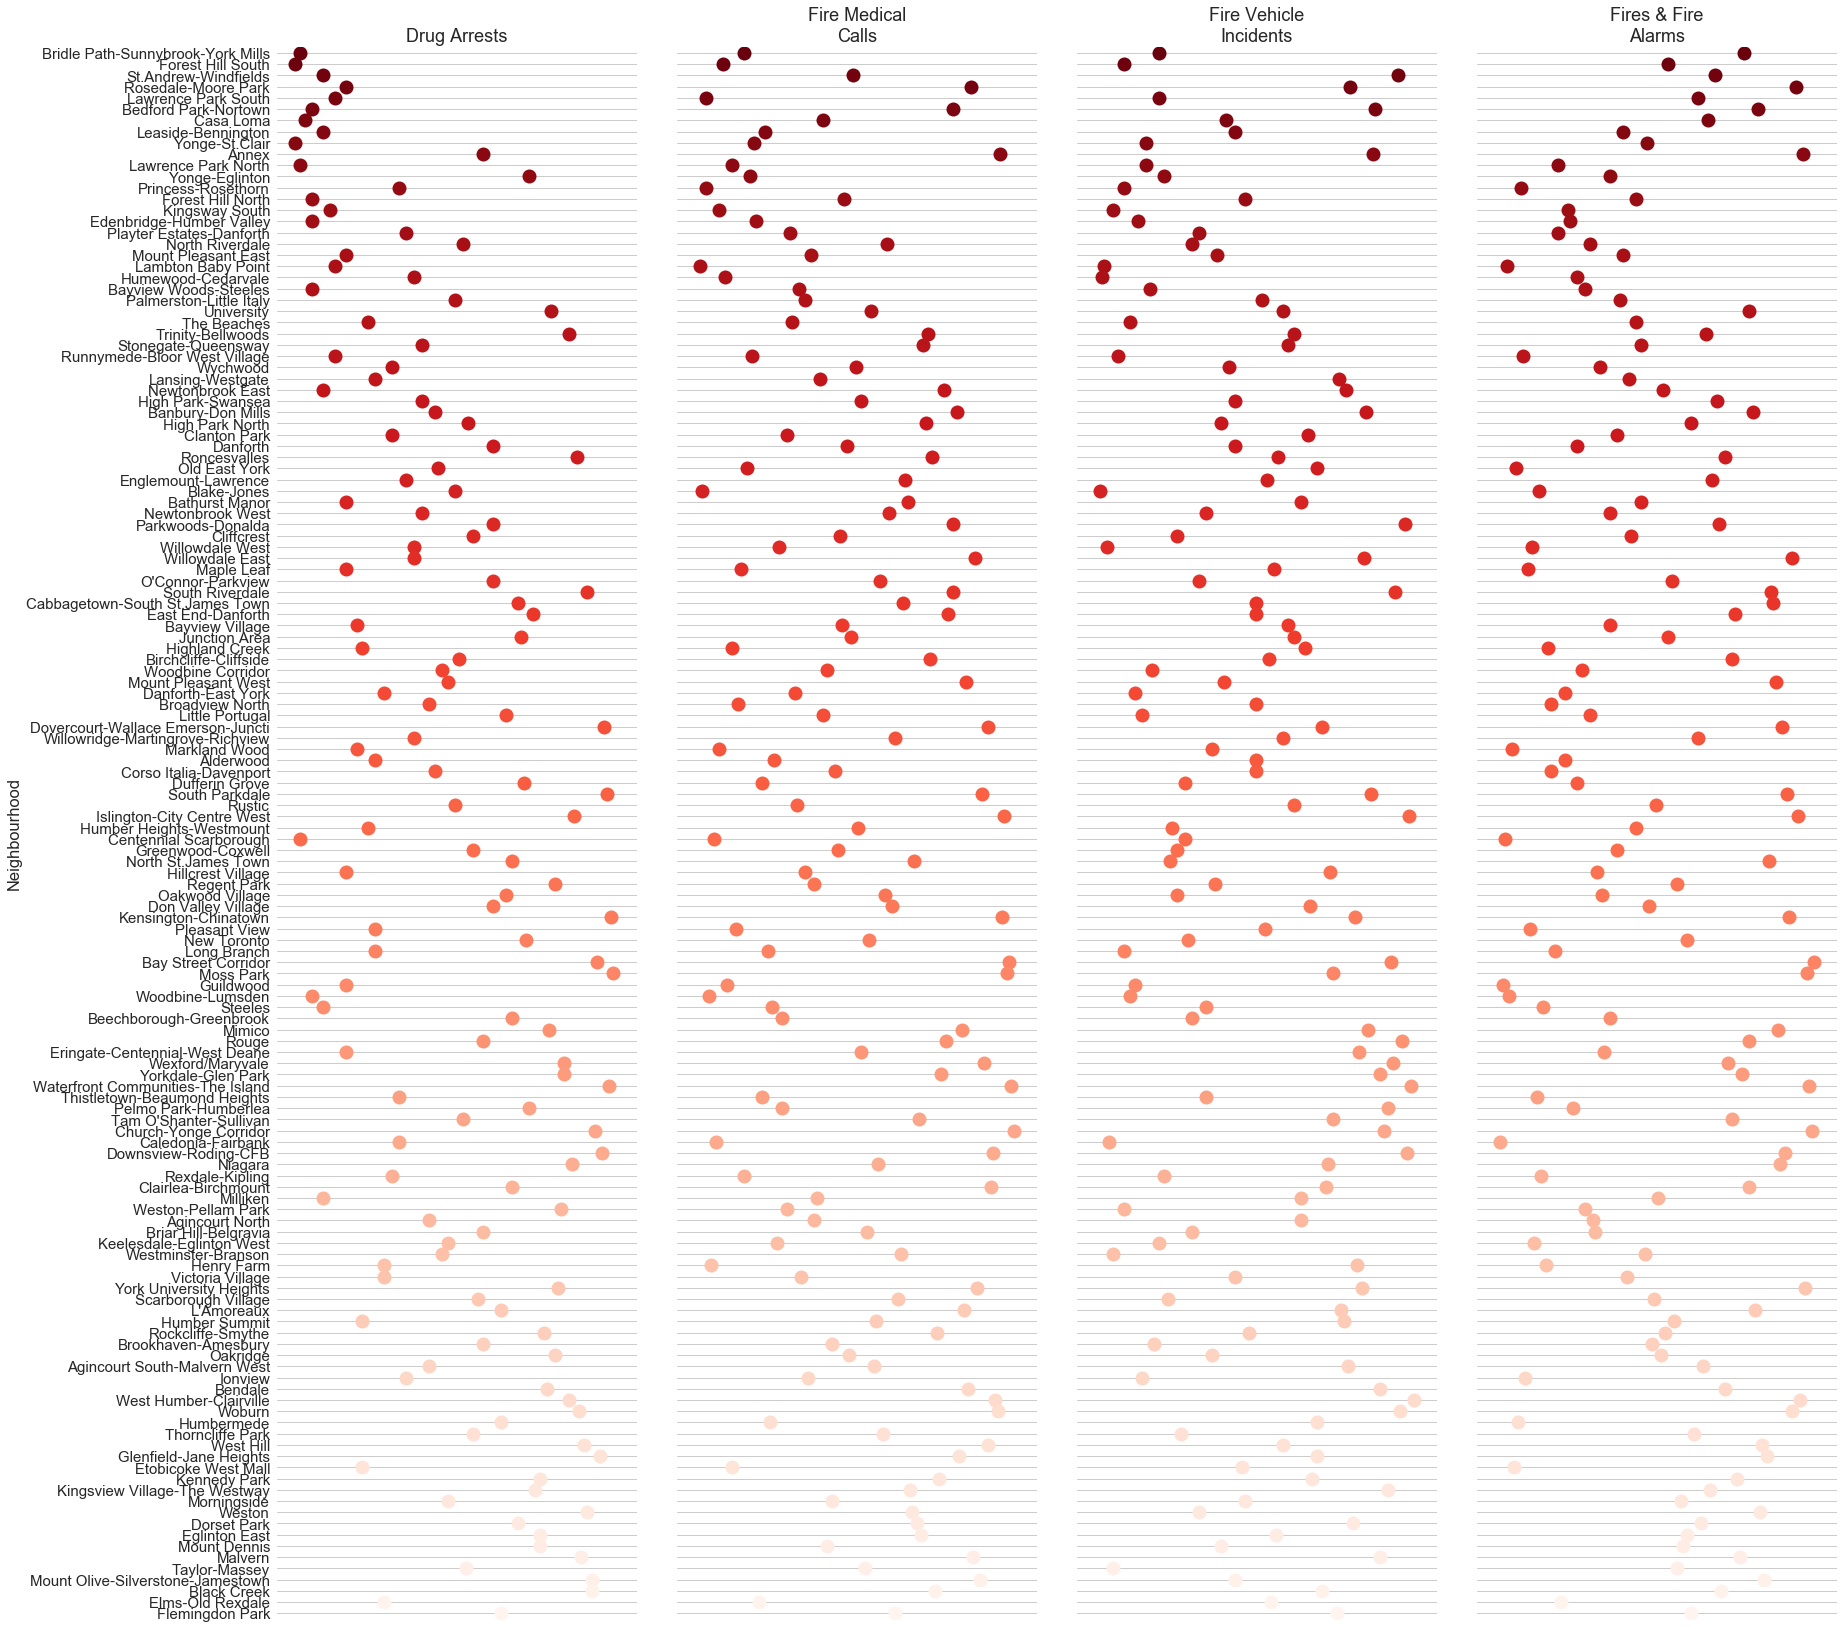

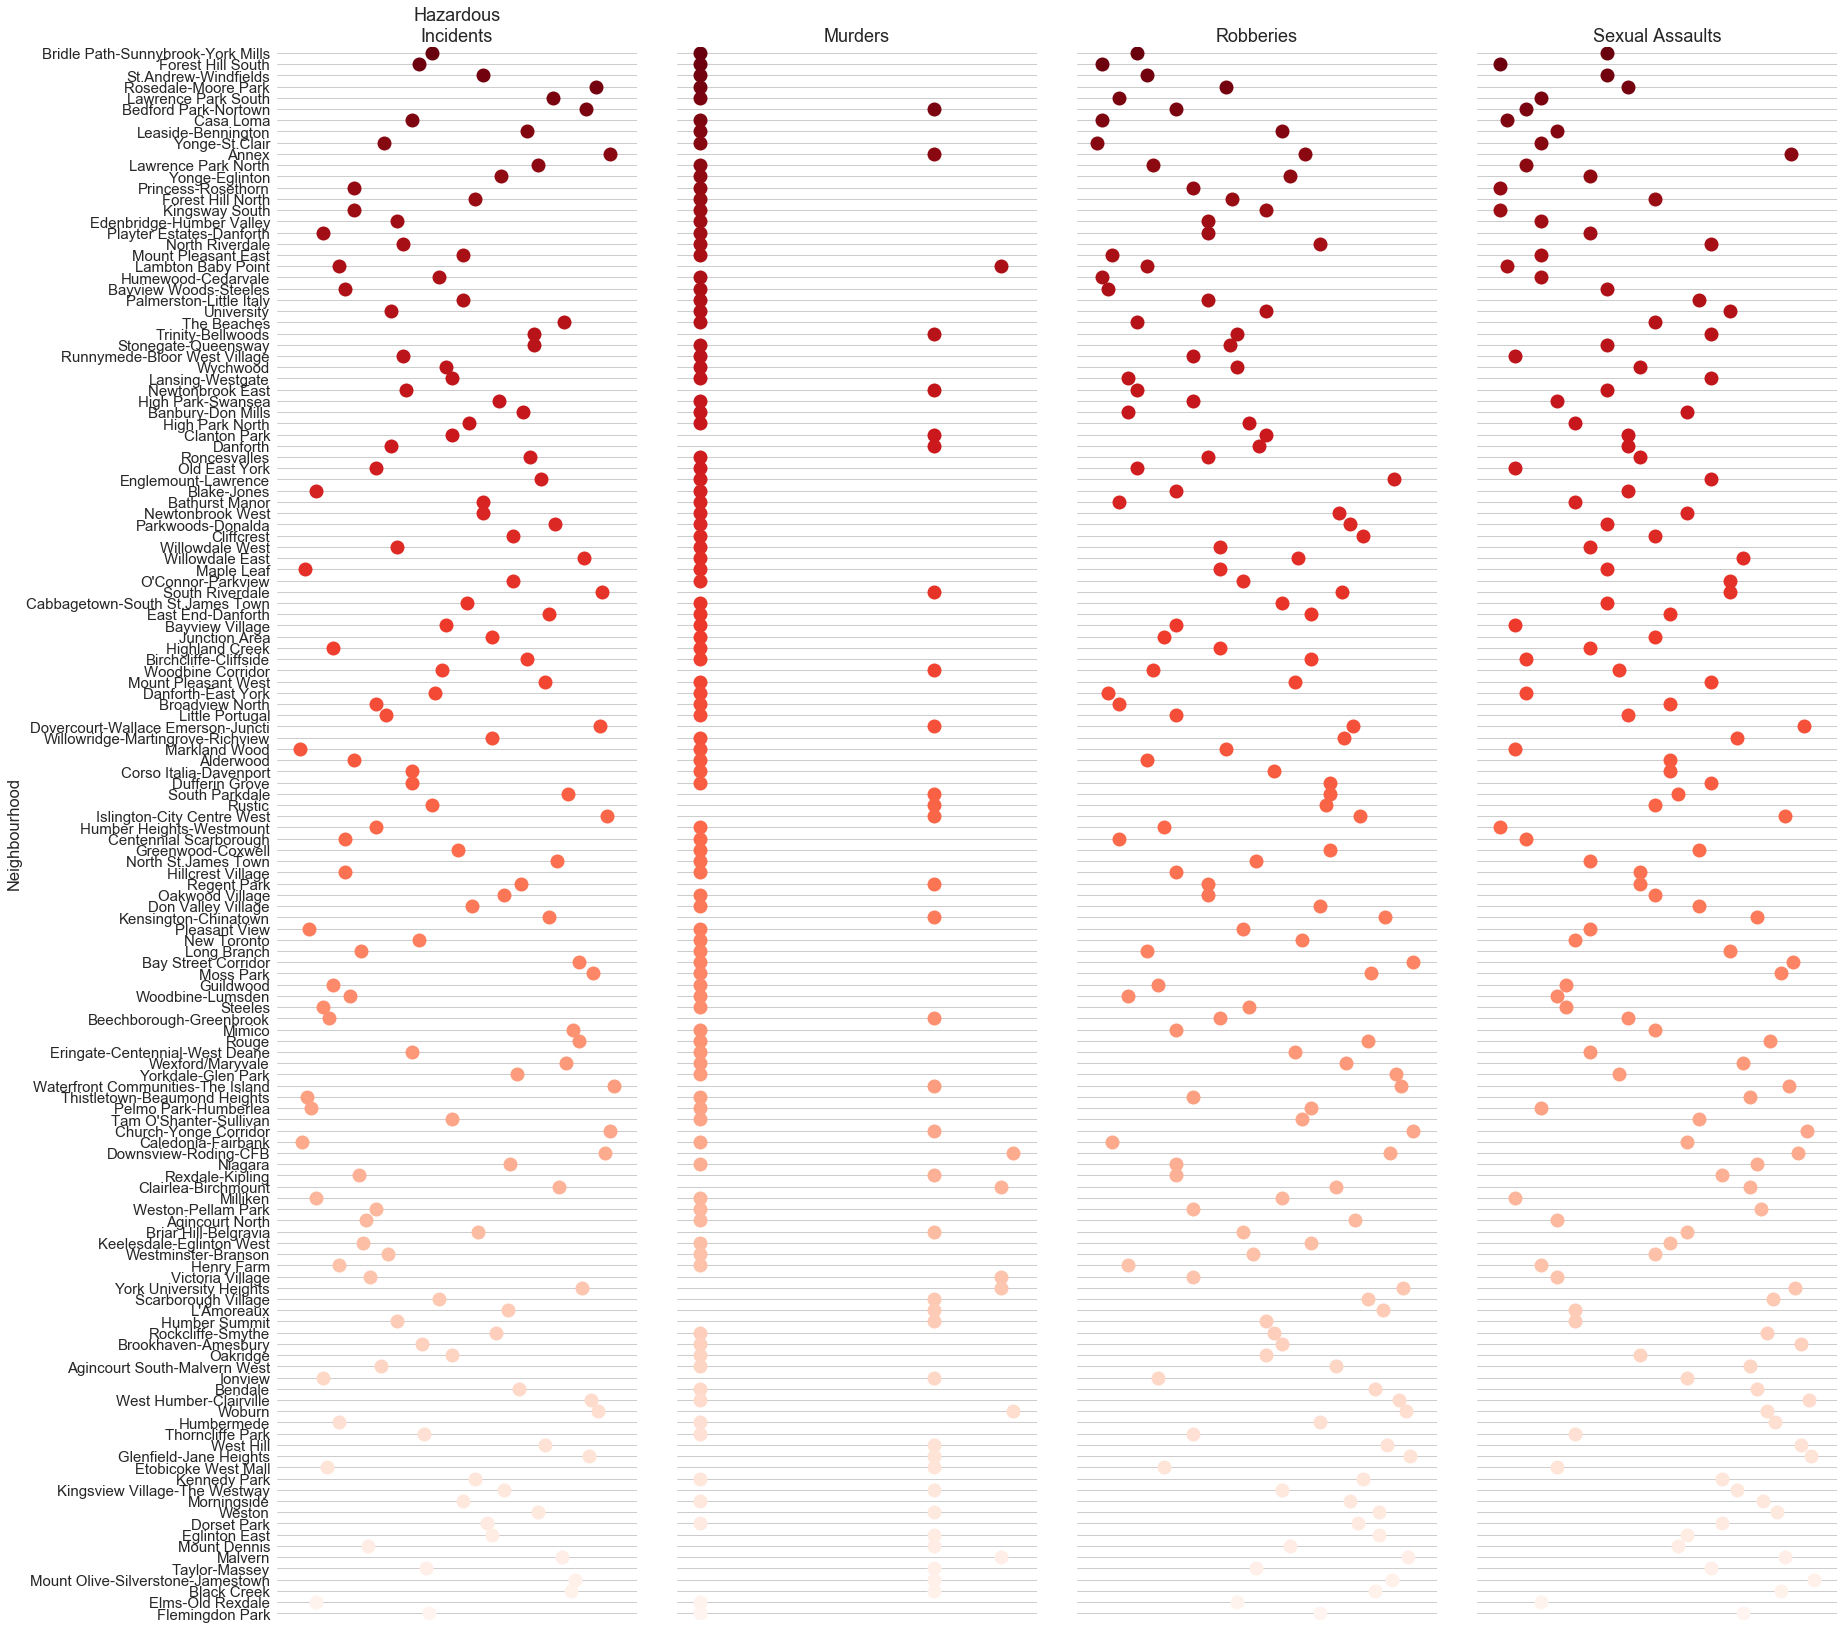

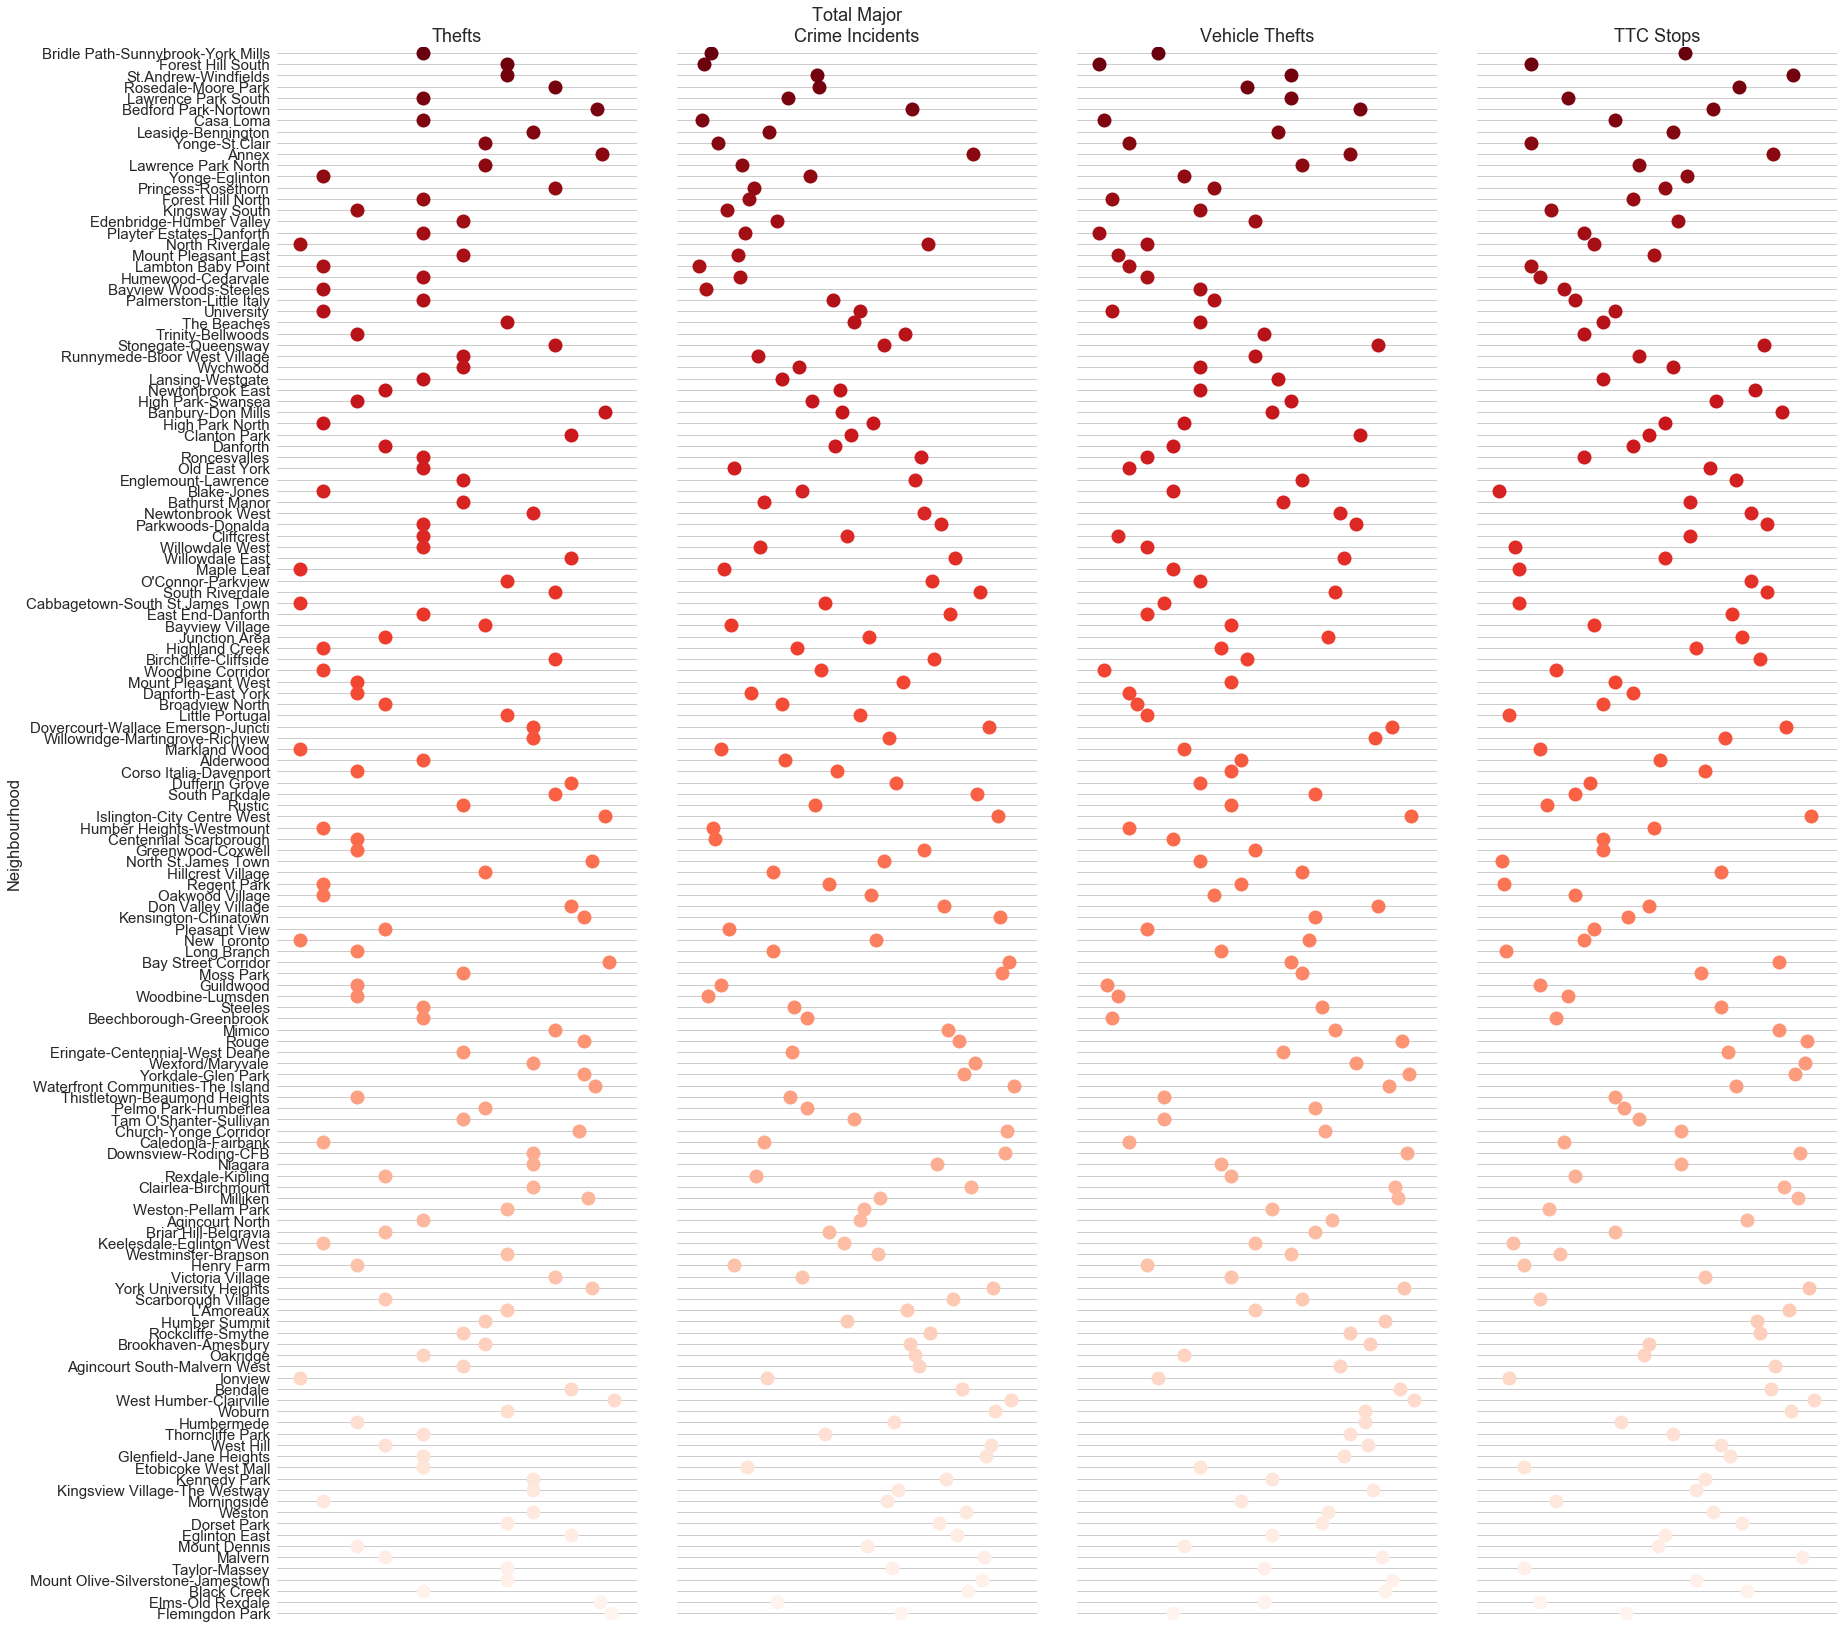

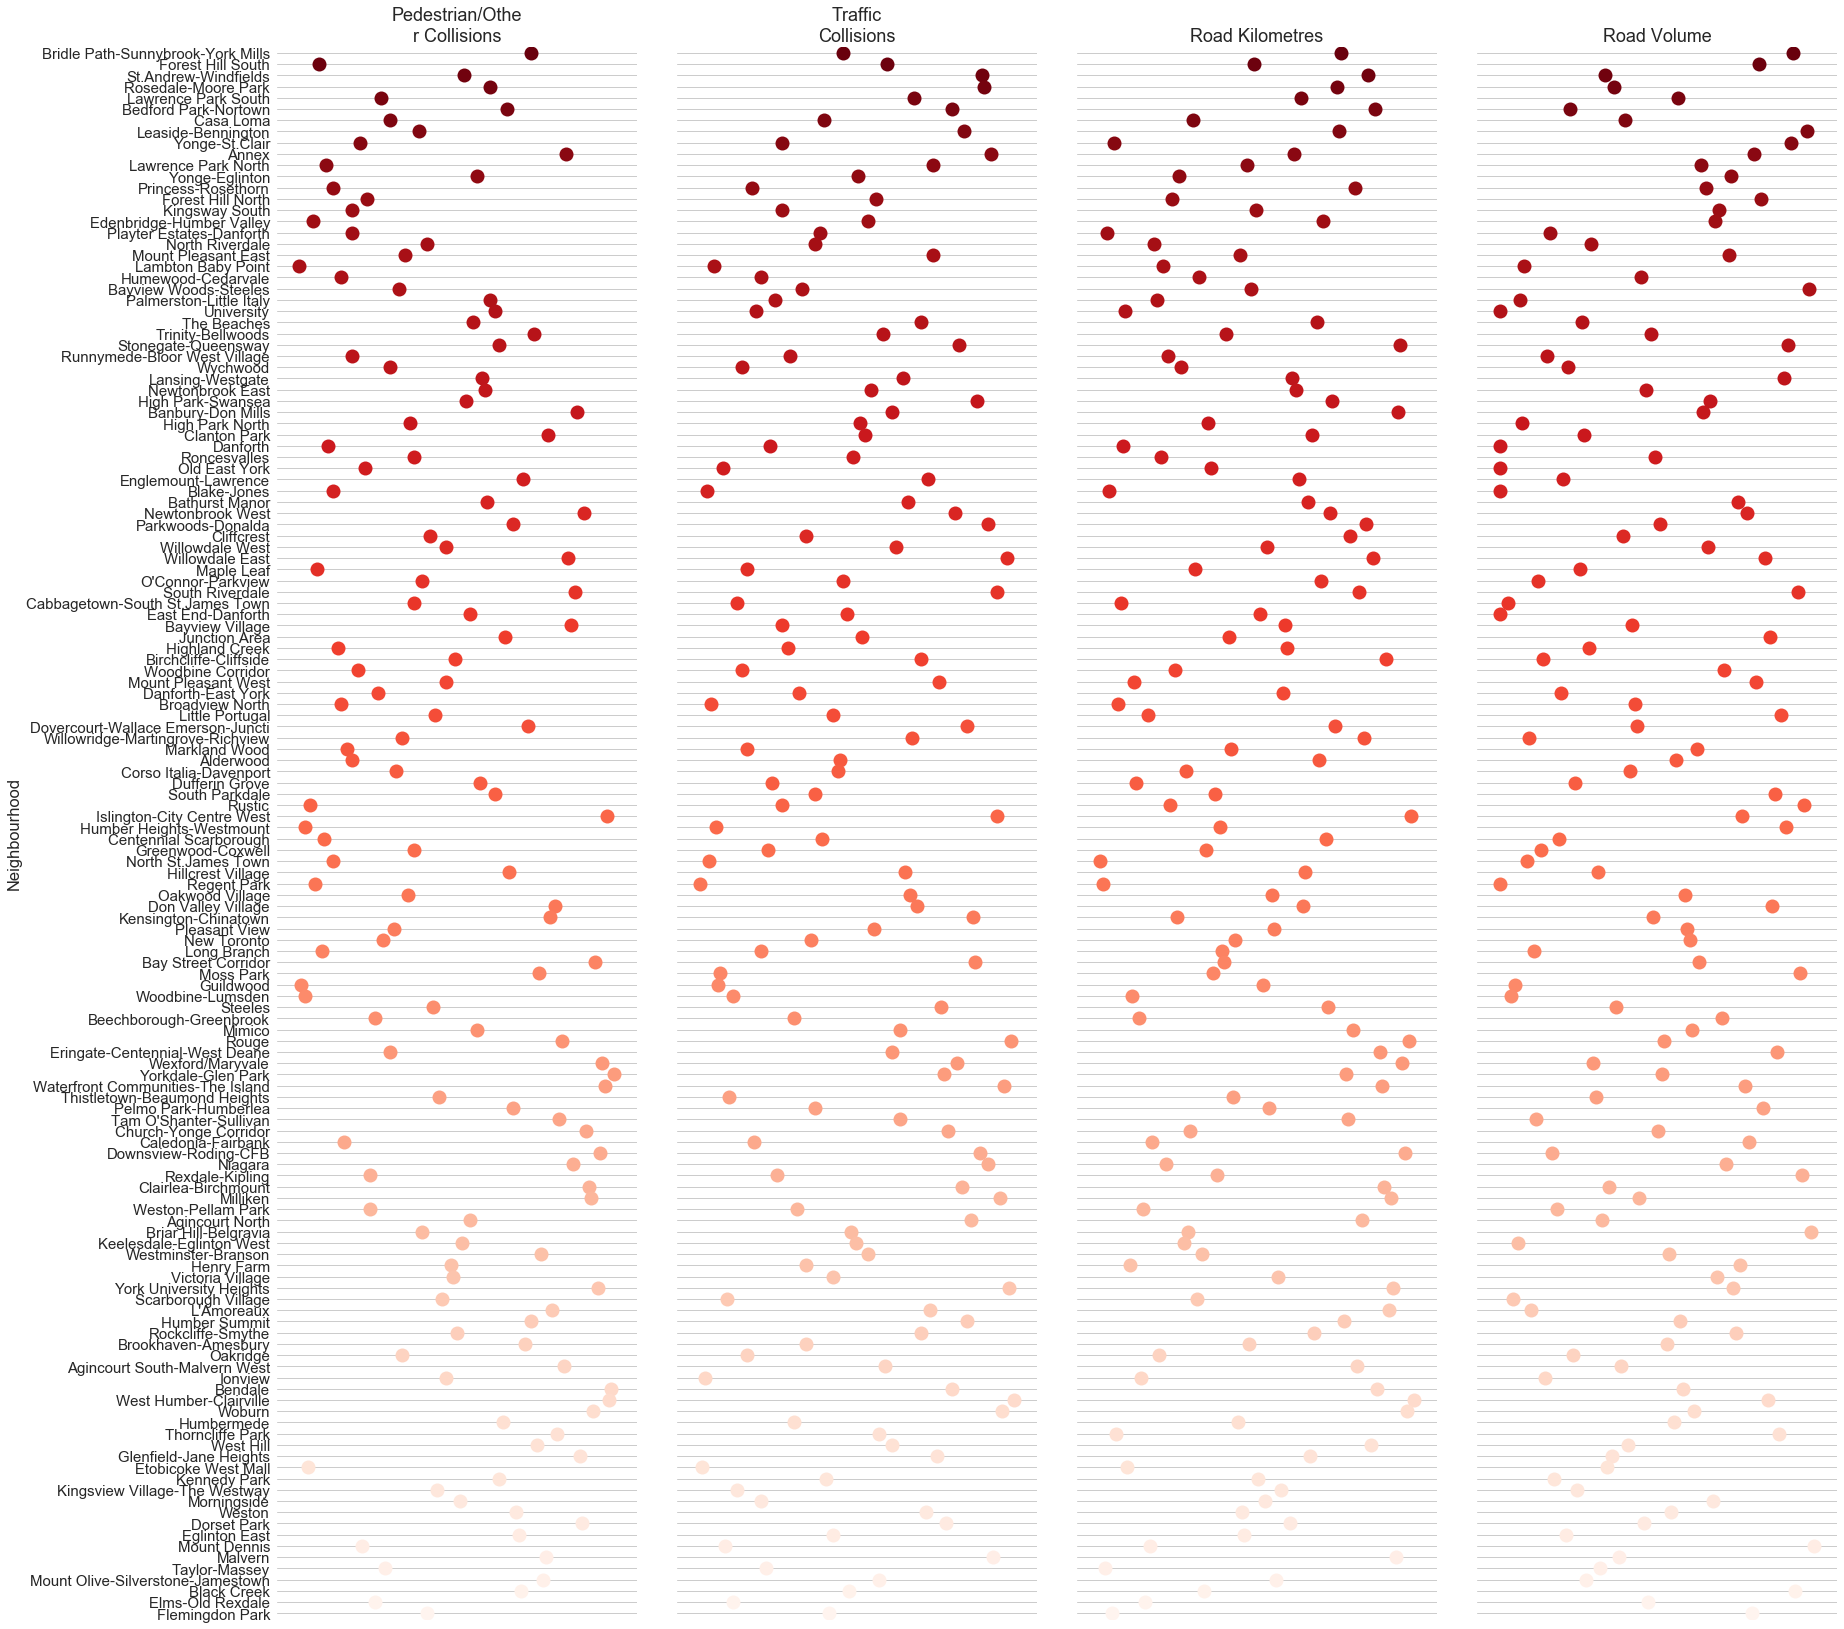

In [57]:
def ranking_plots(df, cols):
    with sns.axes_style("whitegrid"):
        g = sns.PairGrid(df.sort_values("Home Prices", ascending=False),
                         x_vars=cols, y_vars=["Neighbourhood"],
                         size=23, aspect=0.25)

        g.map(sns.stripplot, size=14, orient="h",
              palette="Reds_r", edgecolor="gray")

        for col, ax in zip(cols, g.axes.flat):

            # Set a different title for each axes
            ax.set(title='\n'.join(wrap(col, 15)))
            ax.set_xticks([])
            ax.set_xlabel('')
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)

        sns.despine(left=True, bottom=True)
        
for chunk in np.array_split(feature_cols, 12):
    ranking_plots(df_rank.reset_index(), list(chunk))

In [144]:
def identity(x): return x;
def transformAndPlot(df, transforms, x_col='x', y_col='y'):
    fig, axs = plt.subplots(len(transforms), len(transforms), figsize=(17, 17))
    results = {}
    for ax, transform_pair in zip(axs.flatten(), itertools.product(transforms, transforms)):
        x_transform = df[x_col].apply(transform_pair[0])
        y_transform = df[y_col].apply(transform_pair[1])
        x_name = x_col + '_' + transform_pair[0].__name__
        y_name = y_col + '_' + transform_pair[1].__name__
        
        result = sm.OLS(y_transform, sm.add_constant(x_transform)).fit()
        result_text = 'Slope: %.2e\nIntercept: %.2e\nAdj-R2: %.2f' % (result.params['x'], 
                                                                      result.params['const'], 
                                                                      result.rsquared_adj)
        
        results[x_name + ':' + y_name] = result
        ax.plot(x_transform, y_transform, '.')
        ax.plot(x_transform, result.predict(), '-')
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.text(0.03, 0.82, result_text, transform=ax.transAxes)
    fig.tight_layout()
    return results
def linearRegressionAndResiduals(df, 
                                 x_transform_function=None, y_transform_function=None, 
                                 x_col='x', y_col='y', fit_intercept=True, plot_and_print=True):
    x_transform = df[x_col].apply(x_transform_function) if x_transform_function else df[x_col]
    y_transform = df[y_col].apply(y_transform_function) if y_transform_function else df[y_col]
    result = None
    if fit_intercept:
        result = sm.OLS(y_transform, sm.add_constant(x_transform)).fit()
    else:
        result = sm.OLS(y_transform, x_transform).fit()

    if plot_and_print:
        print(result.summary())
        fig, axs = plt.subplots(nrows=2)
        axs[0].plot(x_transform, y_transform, '.')
        axs[0].plot(x_transform, result.predict(), '-')
        x_name = x_col + '_' + x_transform_function.__name__ if x_transform_function else x_col
        y_name = y_col + '_' + y_transform_function.__name__ if y_transform_function else y_col
        axs[0].set_xlabel(x_name)
        axs[0].set_ylabel(y_name)
        axs[0].set_title('Data and linear fit')

        axs[1].plot(x_transform, y_transform - result.predict(), '.')
        axs[1].set_title('Residuals')
        fig.tight_layout()
    return result

In [143]:
feature_cols = list(cols[:-1])
feature_cols.remove('Home Prices')

final_result = None

r_sqr_list = []
r_sqr_adj_list = []
while(len(feature_cols) > 0):
    result = sm.OLS(df_norm['Home Prices'], sm.add_constant(df_norm[feature_cols])).fit()
    pvalues = result.pvalues.sort_values(ascending=False)
    drop = pvalues.index[1]
    print("***************")
    print("Number of features: {}".format(len(pvalues)))
    print("Rsquared Adj: {:.2f}".format(result.rsquared_adj))
    print("***************")
    print("Dropping feature '{}' with a p-value of {:.4f}".format(drop, pvalues[1]))
    feature_cols.remove(drop)
    r_sqr_list.append(result.rsquared)
    r_sqr_adj_list.append(result.rsquared_adj)
    if result.rsquared < 0.8: break
    final_result = result

***************
Number of features: 52
Rsquared Adj: 0.80
***************
Dropping feature 'Student Nutrition' with a p-value of 0.9869
***************
Number of features: 51
Rsquared Adj: 0.80
***************
Dropping feature 'Arsons' with a p-value of 0.9593
***************
Number of features: 50
Rsquared Adj: 0.80
***************
Dropping feature 'Murders' with a p-value of 0.9509
***************
Number of features: 49
Rsquared Adj: 0.80
***************
Dropping feature 'Vehicle Thefts' with a p-value of 0.9768
***************
Number of features: 48
Rsquared Adj: 0.81
***************
Dropping feature 'Sexual Assaults' with a p-value of 0.9813
***************
Number of features: 47
Rsquared Adj: 0.81
***************
Dropping feature 'Drug Arrests' with a p-value of 0.9634
***************
Number of features: 46
Rsquared Adj: 0.81
***************
Dropping feature 'Traffic Collisions' with a p-value of 0.9161
***************
Number of features: 45
Rsquared Adj: 0.81
***************
Drop

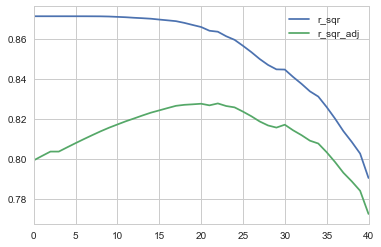

In [141]:
DataFrame({'r_sqr': r_sqr_list, 'r_sqr_adj': r_sqr_adj_list}).plot()

In [142]:
final_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Home Prices   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     43.04
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           6.52e-39
Time:                        21:25:13   Log-Likelihood:                -84.558
No. Observations:                 140   AIC:                             195.1
Df Residuals:                     127   BIC:                             233.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              1.96e-16      0.039   4.99e-15      1.000      -0.078       0.078
Salvation Army Donors               -0.3284      0.072     -4.531      0.000      -0.472      -0.185
Walk Score                           0.2353      0.060      3.938      0.000       0.117       0.354
Linguistic Diversity Index          -0.4422      0.055     -8.009      0.000      -0.552      -0.333
Green Rebate Programs               -0.2236      0.057     -3.943      0.000      -0.336      -0.111
Green Spaces                        -0.6305      0.106     -5.939      0.000      -0.841      -0.420
Pollutant Carcinogenic TEP Score    -0.1186      0.042     -2.805      0.006      -0.202      -0.035
Tree Cover                           0.8760      0.128      6.851      0.000       0.623       1.129
Breast Cancer Screenings             0.2486      0.068      3.663      0.000       0.114       0.383
Premature Mortality                 -0.1967      0.062     -3.186      0.002      -0.319      -0.075
Break & Enters                       0.2435      0.073      3.335      0.001       0.099       0.388
Fires & Fire Alarms                  0.4010      0.093      4.294      0.000       0.216       0.586
Total Major Crime Incidents         -0.4929      0.101     -4.877      0.000      -0.693      -0.293
==============================================================================
Omnibus:                       10.854   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.156
Skew:                           0.462   Prob(JB):                     0.000843
Kurtosis:                       4.255   Cond. No.                         7.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [149]:
cols = df_norm.columns.values

/Users/dpyne/anaconda/envs/helpful-analytics/lib/python3.6/site-packages/numpy/linalg/linalg.py:1591: RuntimeWarning: invalid value encountered in greater
  return sum(S > tol)
/Users/dpyne/anaconda/envs/helpful-analytics/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/dpyne/anaconda/envs/helpful-analytics/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/dpyne/anaconda/envs/helpful-analytics/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                            OLS Regression Results                            
Dep. Variable:            Home Prices   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 30 Nov 2017   Prob (F-statistic):                nan
Time:                        19:39:14   Log-Likelihood:                    nan
No. Observations:                 140   AIC:                               nan
Df Residuals:                     140   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

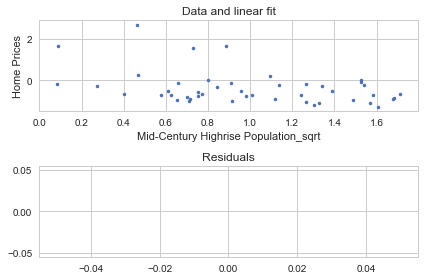

In [153]:
linearRegressionAndResiduals(df_norm, x_col=cols[2], y_col=cols[0], x_transform_function=np.sqrt)

                            OLS Regression Results                            
Dep. Variable:            Home Prices   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     8.731
Date:                Tue, 28 Nov 2017   Prob (F-statistic):            0.00368
Time:                        19:35:43   Log-Likelihood:                -193.86
No. Observations:                 140   AIC:                             391.7
Df Residuals:                     138   BIC:                             397.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

/Users/dpyne/anaconda/envs/helpful-analytics/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


                            OLS Regression Results                            
Dep. Variable:            Home Prices   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     114.1
Date:                Tue, 28 Nov 2017   Prob (F-statistic):           8.65e-20
Time:                        19:35:50   Log-Likelihood:                -155.96
No. Observations:                 140   AIC:                             315.9
Df Residuals:                     138   BIC:                             321.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

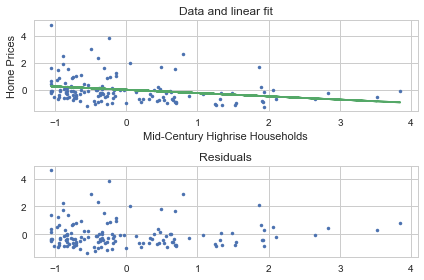

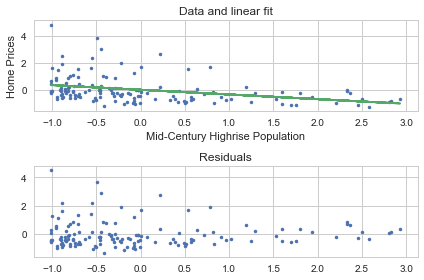

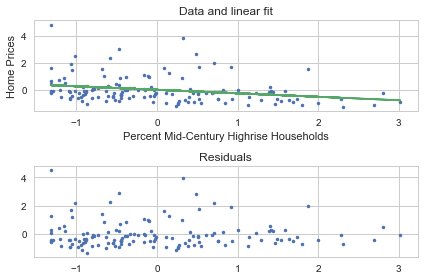

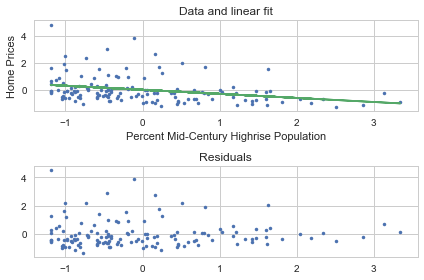

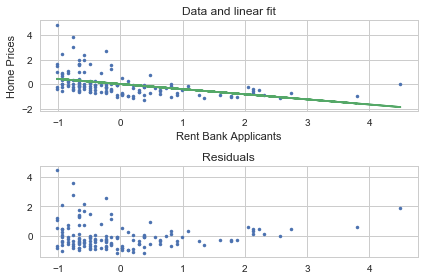

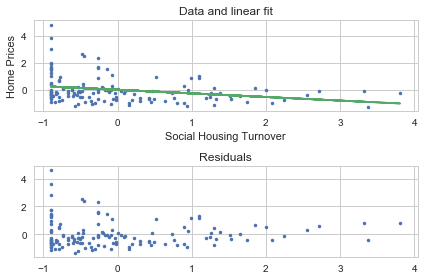

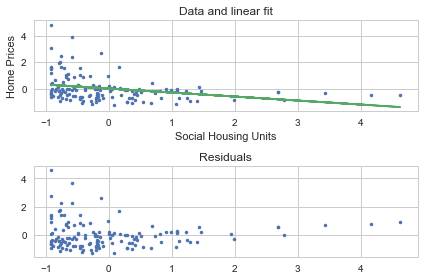

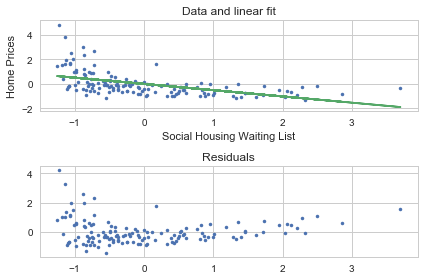

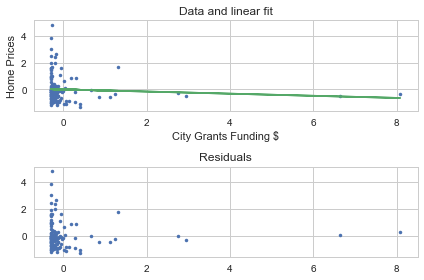

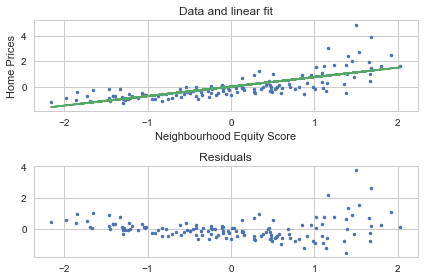

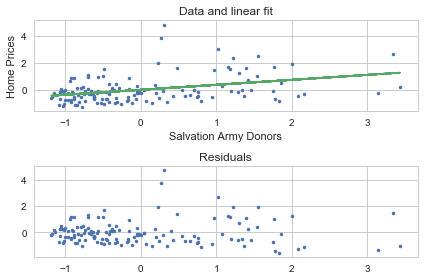

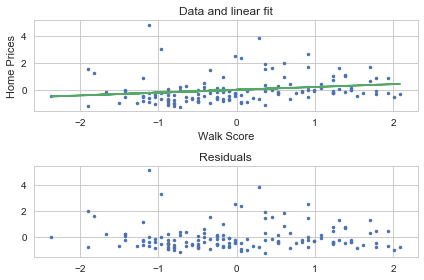

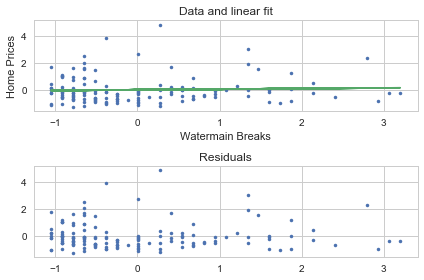

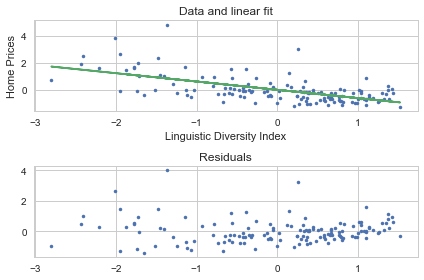

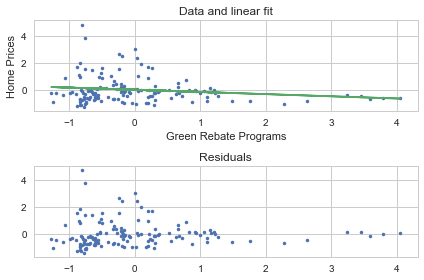

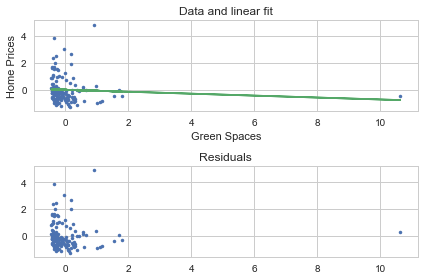

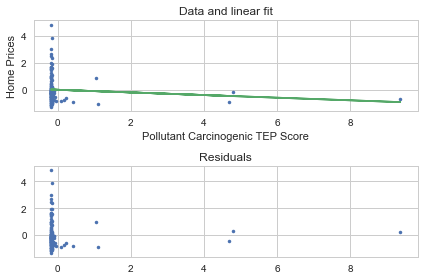

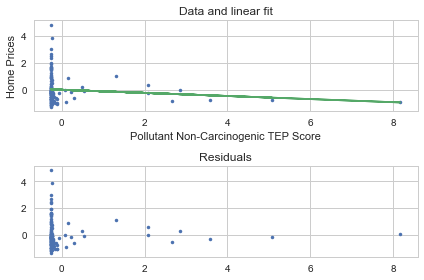

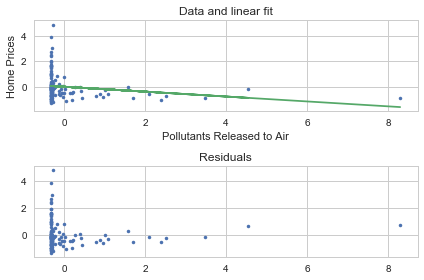

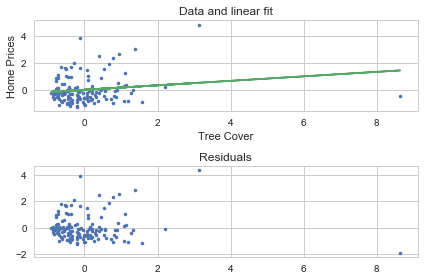

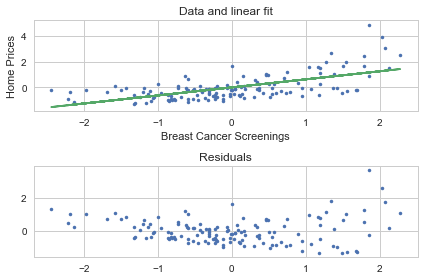

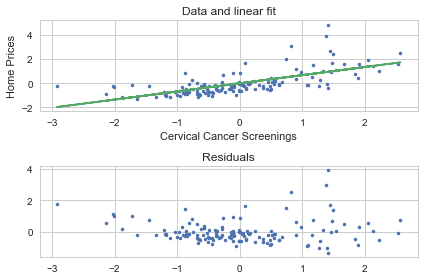

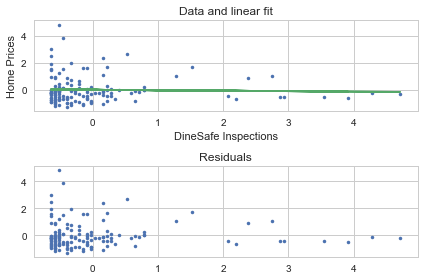

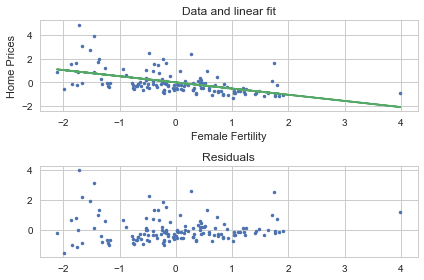

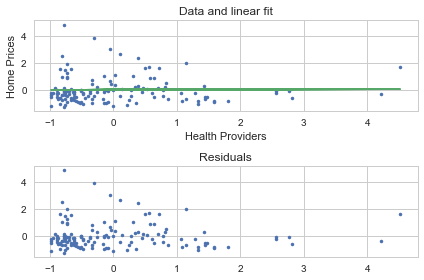

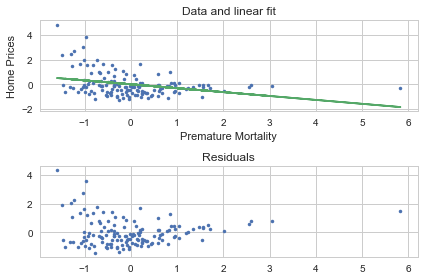

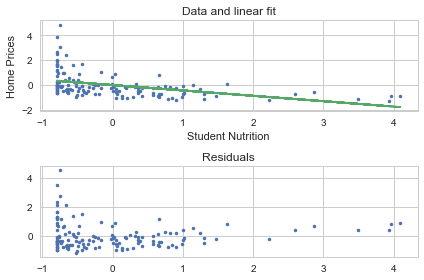

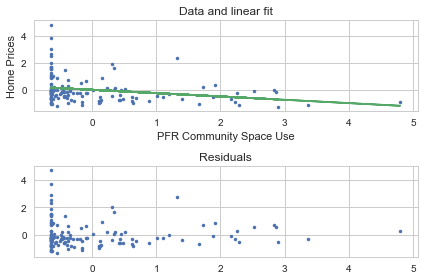

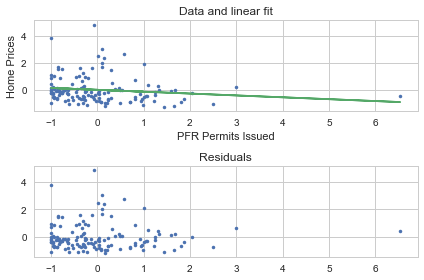

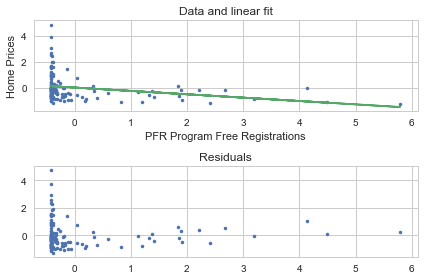

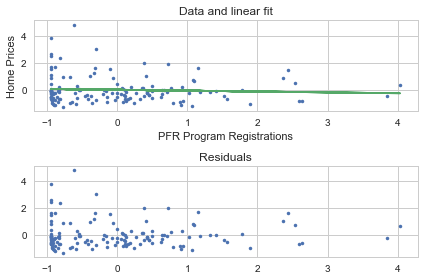

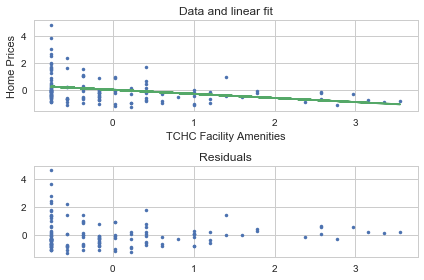

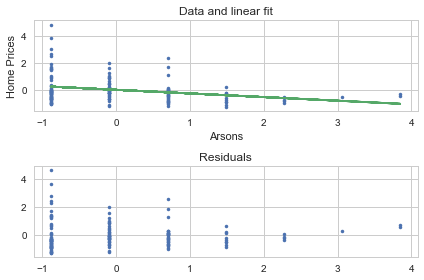

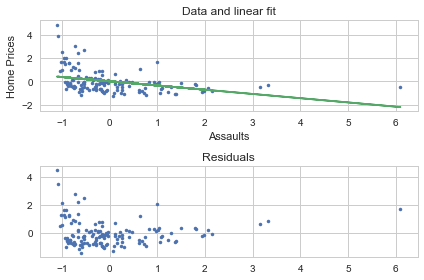

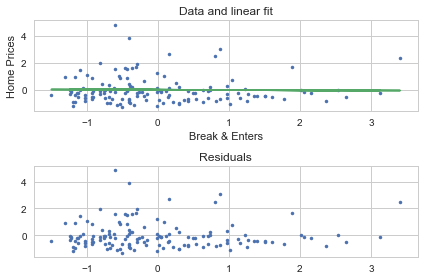

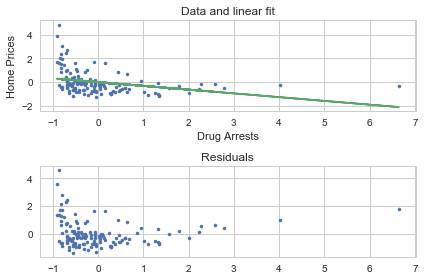

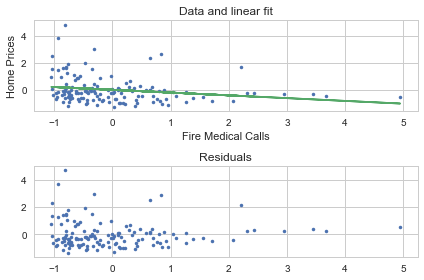

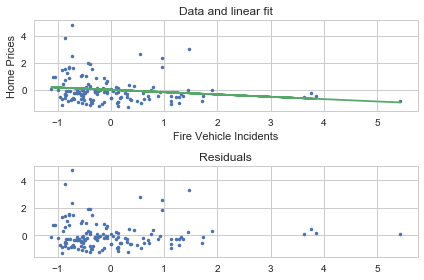

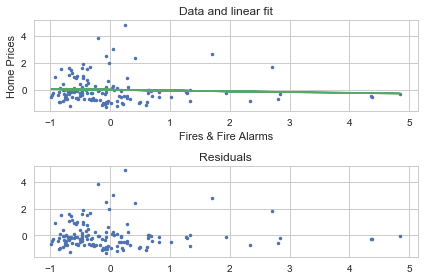

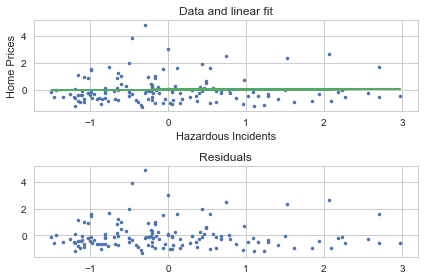

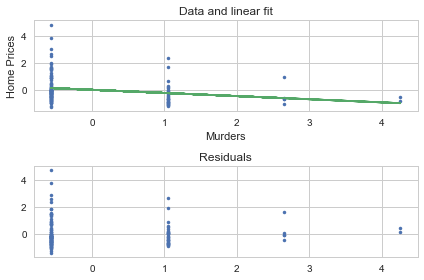

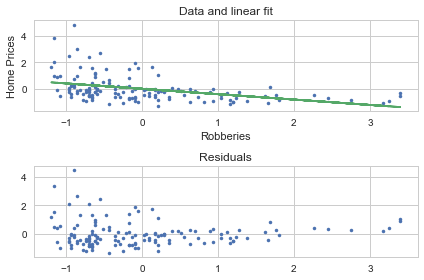

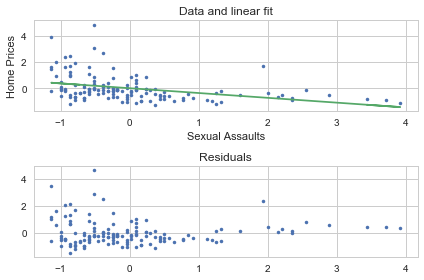

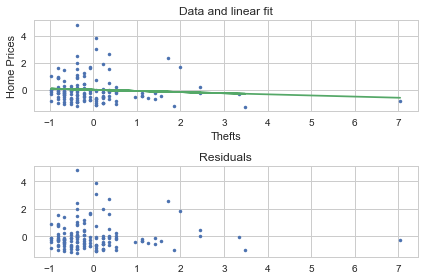

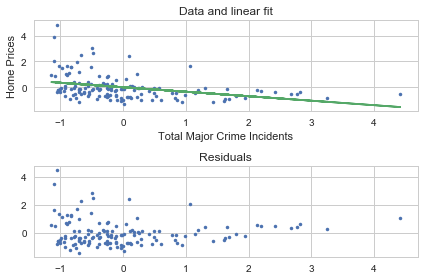

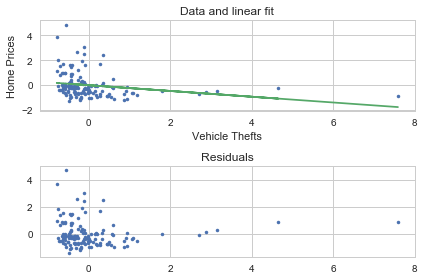

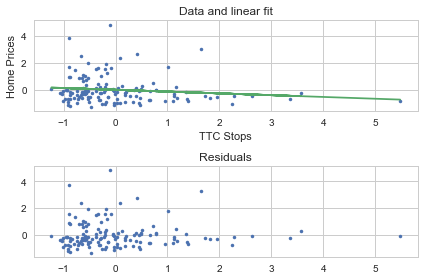

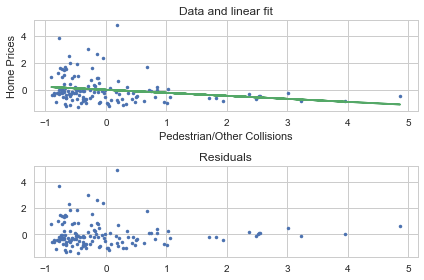

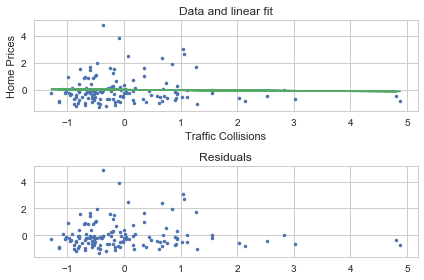

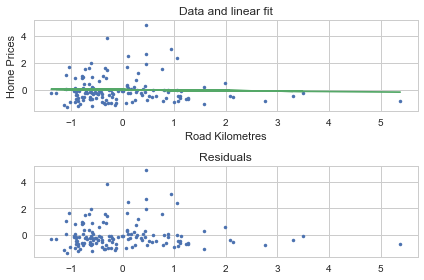

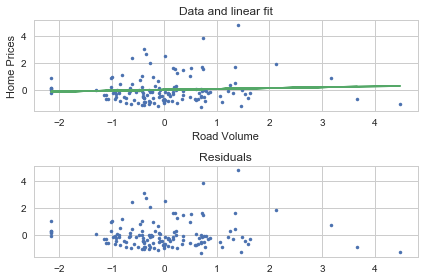

In [83]:
for c in cols[1:]:
    linearRegressionAndResiduals(df_norm, x_col=c, y_col=cols[0])